# Simulation: The Art of Gaining Statistical Insights without Doing Math

Statistics is hard, but useful.

Using simple programming techniques, you can gain all the statistical insight you need, without doing any math. As well as statistical insight, these approaches usually lead to deeper intuition about the thing you're studying.

The contention I'll make in this session is that the most important aspect of gaining statistical insight is asking the right question (not math). We'll go through some examples.

## What is the chance that the day of month TLT seasonality effect might be observed by chance?

A reasonably well known market anomaly is the tendency for bonds to exhibit monthly seasonality where they tend to appreciate towards the end of the month, and depcreciate at the start of the month.

I'll show you what it looks like using data for TLT (a long-dated US treasury ETF) obtained from Yahoo Finance.

First, load the libraries we'll need for our analysis and set our plot options:

In [1]:
# load libraries
library(tidyverse)
library(lubridate)
library(glue)
library(httr)

# set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Here are some functions for getting price data from Yahoo Finance:

In [2]:
#' Parse a Yahoo! Finance prices unofficial API response object to dataframe
#' @param response: response object from call to https://query1.finance.yahoo.com/v7/finance/download
#' return dataframe of price data
parse_yahoo_prices <- function(response) {
  response %>%
    content(as = "text", encoding = "UTF-8") %>%
    read.table(text = ., sep=",", fill = TRUE, header = TRUE, stringsAsFactors = FALSE) %>%
    mutate(Date = as.Date(Date))
}


#' Get historical prices from Yahoo! Finance unofficial API
#' @param ticker: price ticker eg "TSLA"
#' @param from_date: start date in format "YYYY-MM-DD"
#' @param end_date: end date in format "YYYY-MM-DD"
#' @return dataframe of price data
single_ticker_prices_yahoo <- function(ticker, from_date, to_date = Sys.Date()) {
  base_url = "https://query1.finance.yahoo.com/v7/finance/download"

  period1 = as.numeric(as.POSIXct(from_date, format = "%Y-%m-%d"))
  period2 = as.numeric(as.POSIXct(to_date, format = "%Y-%m-%d"))

  resp <- httr::GET(glue::glue("{base_url}/{ticker}"), query = list(period1 = period1, period2 = period2, interval = "1d", events = "history", includeAdjustedClose = "true"))

  parse_yahoo_prices(resp)
}

And here we grab some TLT data, look at the first few rows, and plot the adjusted closing prices:

In [68]:
tlt <- single_ticker_prices_yahoo("BTC-USD", from_date = "2014-10-01")
tlt %>% tail

Date       Open     High     Low      Close    Adj.Close Volume     
3403 2024-01-24 39877.59 40483.79 39508.80 40077.07 40077.07  22359526178
3404 2024-01-25 40075.55 40254.48 39545.66 39933.81 39933.81  18491782013
3405 2024-01-26 39936.82 42209.39 39825.69 41816.87 41816.87  25598119893
3406 2024-01-27 41815.62 42195.63 41431.28 42120.05 42120.05  11422941934
3407 2024-01-28 42126.12 42797.18 41696.91 42035.59 42035.59  16858971687
3408 2024-01-29 42030.91 42457.75 41897.94 41974.50 41974.50  14921853952

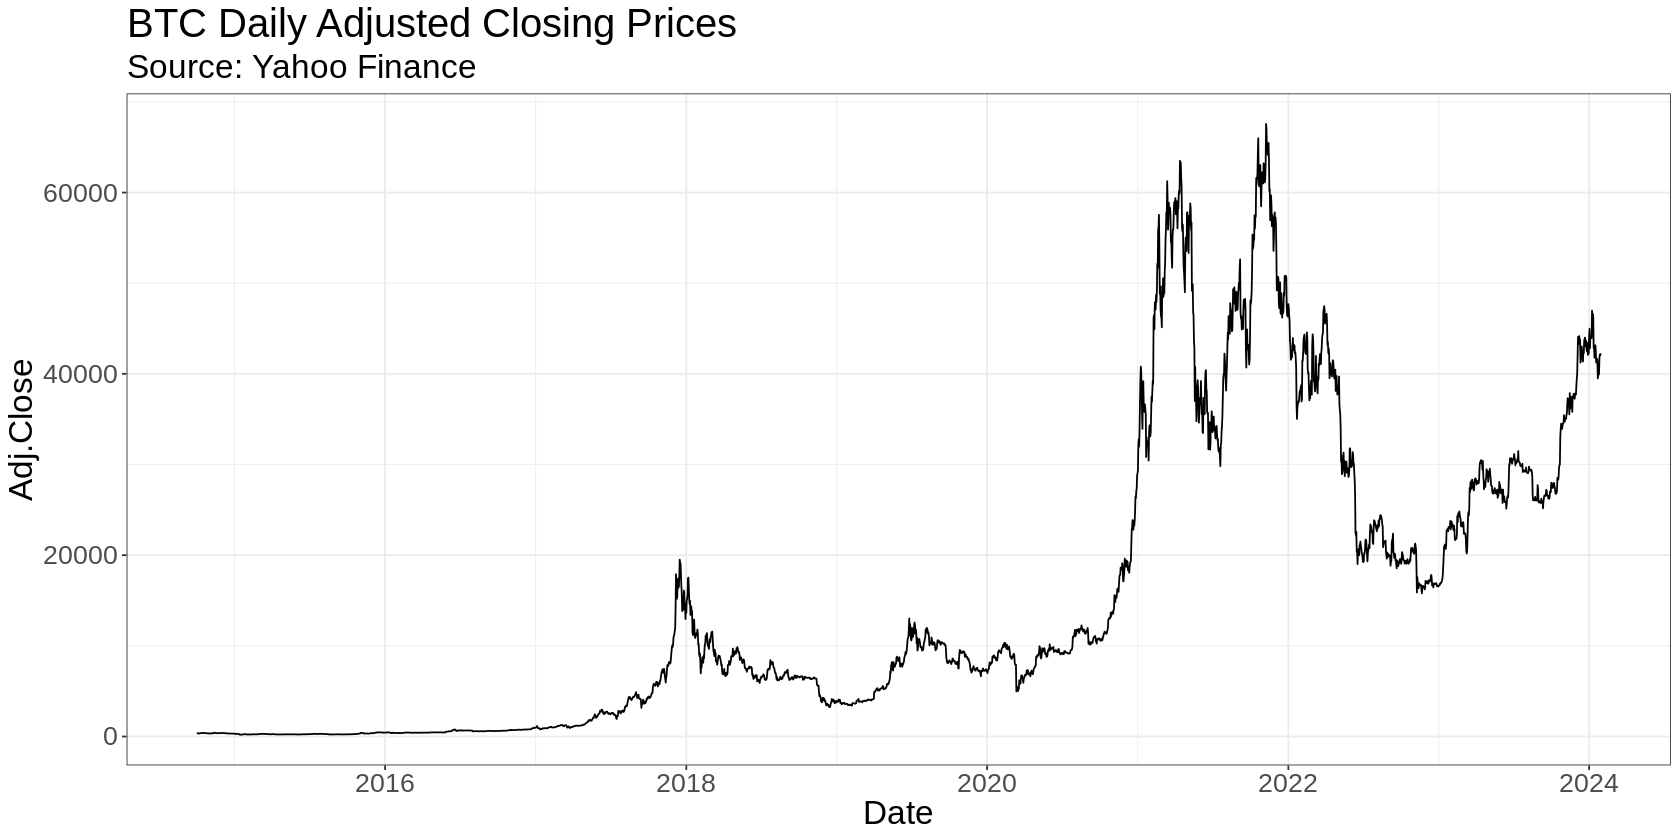

In [4]:
tlt %>%
  ggplot(aes(x = Date, y = Adj.Close)) +
    geom_line() +
    labs(
      title = "BTC Daily Adjusted Closing Prices",
      subtitle = "Source: Yahoo Finance"
    )

To look at monthly seasonality, we'll need to aggregate returns to each trading day of the month.

To do that, we'll need the following operations:
- Make variables for the year and month, so that we can uniquely identify rows by year and month (and later group (aggregate) our data by month)
- Remove any incomplete months
- Make a variable representing "trading day of the month"
- Calculate the mean return to each trading day of the month. We'll also count the number of each trading day in our sample.

In [5]:
# make year, month, and day variables
tlt <- tlt %>%
  mutate(
    year = year(Date), month = month(Date), day = day(Date)
  ) %>%
  mutate(log_return = log(Adj.Close/dplyr::lag(Adj.Close))) %>%
  na.omit()

# get rid of incomplete months
incomplete_months <- tlt %>%
  group_by(year, month) %>%
  summarise(trading_days = n(), .groups = "keep") %>%
  filter(trading_days < 15)

tlt <- tlt %>%
  anti_join(incomplete_months, by = c("year", "month"))

# make trading day of the month variable
tlt_trading_days <-  tlt  %>%
  group_by(year, month) %>%
  mutate(trading_dom = row_number())

# look at our modified data
tlt_trading_days %>% head

Date       Open    High    Low     Close   Adj.Close Volume   year month day
1 2014-10-02 383.988 385.497 372.946 375.072 375.072   21777700 2014 10    2  
2 2014-10-03 375.181 377.695 357.859 359.512 359.512   30901200 2014 10    3  
3 2014-10-04 359.892 364.487 325.886 328.866 328.866   47236500 2014 10    4  
4 2014-10-05 328.916 341.801 289.296 320.510 320.510   83308096 2014 10    5  
5 2014-10-06 320.389 345.134 302.560 330.079 330.079   79011800 2014 10    6  
6 2014-10-07 330.584 339.247 320.482 336.187 336.187   49199900 2014 10    7  
  log_return  trading_dom
1 -0.02252144 1          
2 -0.04237045 2          
3 -0.08909717 3          
4 -0.02573686 4          
5  0.02941854 5          
6  0.01833554 6

In [6]:
# calculate mean return to each trading day, and get a count of the number of each trading day in our sample
tlt_trading_day_returns <- tlt_trading_days %>%
  group_by(trading_dom) %>%
  summarise(
  mean_return = mean(log_return),
  count_of_trading_days = n()
)

tlt_trading_day_returns

trading_dom mean_return   count_of_trading_days
1   1           0.0062417374 112                  
2   2           0.0062769320 112                  
3   3           0.0016624577 112                  
4   4          -0.0001760650 112                  
5   5           0.0042045223 112                  
6   6           0.0053569301 112                  
7   7           0.0028983085 112                  
8   8           0.0008239712 112                  
9   9          -0.0010634794 112                  
10 10          -0.0085068662 112                  
11 11          -0.0015916121 112                  
12 12           0.0006858493 112                  
13 13           0.0023648820 112                  
14 14          -0.0031544235 112                  
15 15           0.0017541368 112                  
16 16           0.0001774133 112                  
17 17           0.0030795772 112                  
18 18          -0.0022945688 112                  
19 19           0.0049765608 112                  
20 20           0.0071743268 112                  
21 21          -0.0099689523 112                  
22 22          -0.0033223761 112                  
23 23           0.0055790414 112                  
24 24          -0.0030840739 112                  
25 25           0.0007510019 112                  
26 26           0.0042459108 112                  
27 27           0.0063661248 112                  
28 28           0.0052212762 112                  
29 29           0.0042159347 105                  
30 30           0.0001678455 102                  
31 31           0.0021007455  64

Plotting the mean return to each trading day of the month shows a clear but noisy pattern where returns at the start of the month tend to be lower than average, and returns at the end of the month tend to be higher than average:


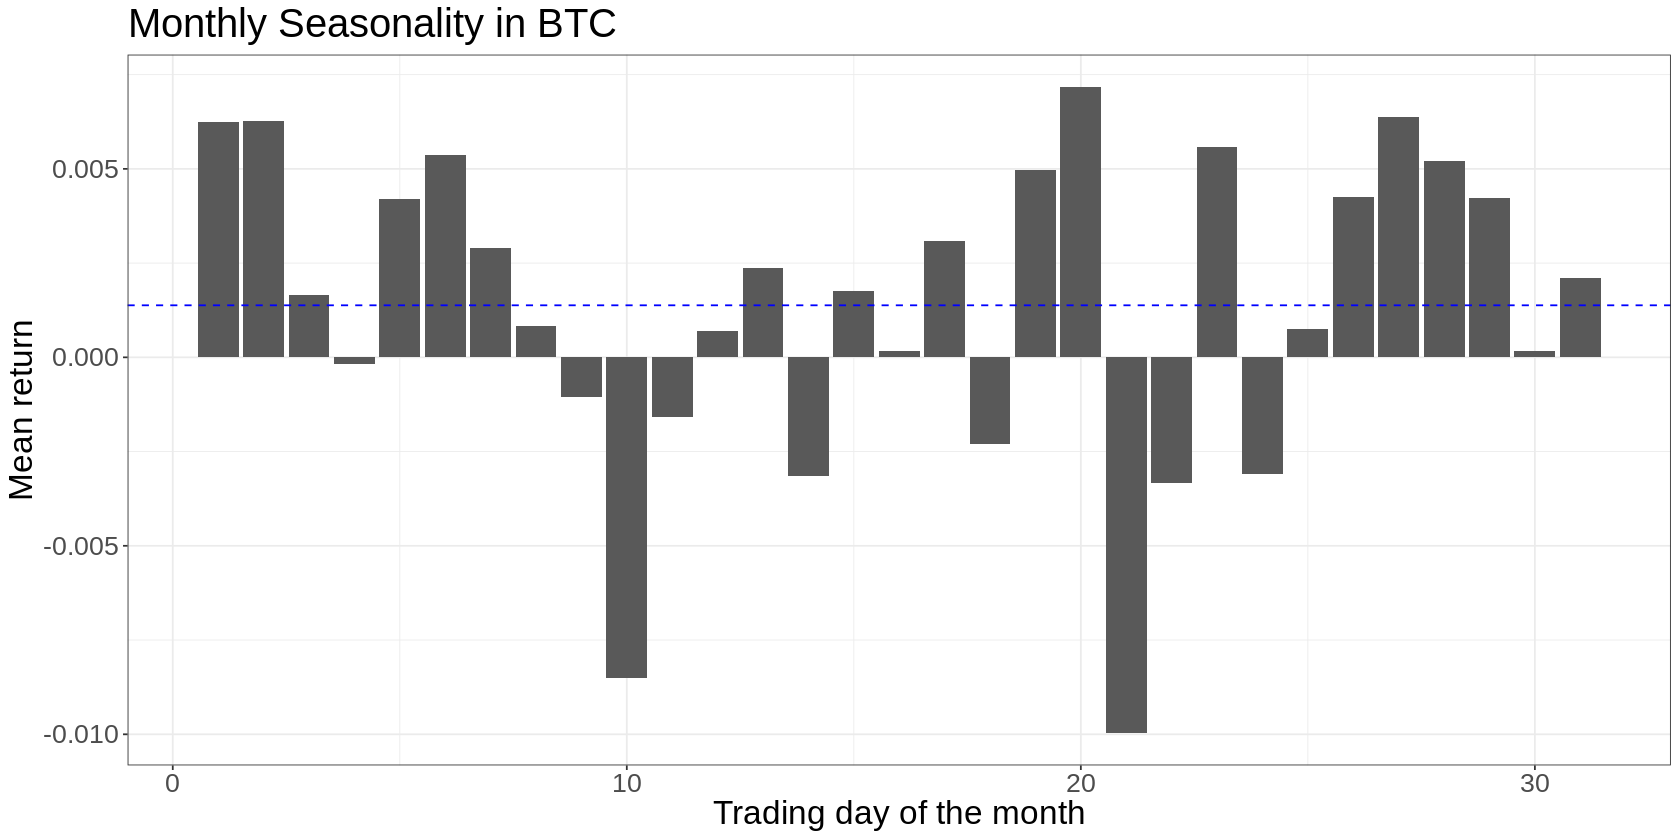

In [7]:
mean_daily_return <- mean(tlt$log_return)

tlt_trading_day_returns %>%
  ggplot(aes(x = trading_dom, y = mean_return)) +
    geom_bar(stat = "identity") +
    geom_hline(yintercept = mean_daily_return, colour = "blue", linetype = "dashed") +
    labs(
    x = "Trading day of the month",
    y = "Mean return",
    title = "Monthly Seasonality in BTC"
    )

The effect *looks* highly non-random.

But is it?

What are the chances of TLT monthly seasonality looking like this by chance?

The first step in answering this question *isn't* to jump straight into statistics. A better place to start is to figure out *why* our data might look like this. Is there a good structural, economic, or behavioural effect that could explain this anomaly?

(The reason it's important to start here is that if we look at enough ideas like this, we'll eventually find something that *does* look very good, purely by chance. If we have something rational that might explain it, we're in a better place to make good decisions as to what to do about it).

So what might explain such an effect?

It *might* be due to "window dressing" flows, where portfolio managers seek to shore up gains made earlier in the month, or to remove holdings they'd rather not disclose before the reporting period. That additional buying pressure at the end of the month would tend to increase the price of bonds, while the additional selling pressure at the start of the month would tend to decrease it.

**Is this an adequate explanation?**

People buy and sell bonds for all sorts of reasons. So you have to be very careful bluntly attributing effects to specific causes. At best we can hypothesise about what might happen very noisily and on average.

But that aside, I think our hypothesis isn't completely crazy. It makes sense given what we know about markets and their participants.

So we've got a possible explanation for what we see in the data. But that's not really enough. We like to look at things from a few different angles and gather as much evidence as we can.

*One nagging issue is that it's entirely possible that our TLT seasonality data might look the way it does purely by chance.*

The problem is that we only observe one run of reality, and our effect is very noisy (it doesn't happen all the time, only on average). This makes it hard to tell whether interesting things are just random or real anomalies of the data generating process - which we can't see.

It's like the coin flipping experiment. We all know that if we flip a coin ten times, we'd expect heads and tails to each come up 5 times. We also know and accept that sometimes we'd see 4 of one and 6 of the other, or even 3 of one and 7 of the other. We'd also very occassionally see even more extreme results.

If we ran thousands of our ten-coin-flip experiments, we'd observe a *ton* of results that deviated from our expectation.

What if we just did a single experiment and that particular run of history happened to get an extreme result? Wouldn't it be nice to be able to quantify the likelihood of seeing that result by chance alone?

*That's what we're going to do next.*

We'll use simulation to generate thousands of runs of our TLT history by randomly shuffling the order of returns. And then, we'll calculate how often we see seasonality effects in the randomised data, like we see in our actual data. This will give us a measure of how likely we are to see our actual results through chance alone.

This measure is what statistics people call a *p-value*. And we're going to use simple computational tools, as opposed to complicated math, to calculate it for our effect.



### What's the right question to ask?

To frame an appropriate question, we need to think about what we're trying to understand.

A reasonable first question might be *"what are the chances of seeing a trading-day-of-the-month return as high or low as the extremes we see in our data?"* (days 3 and and 22 for example).

This might be OK, but it doesn't really reflect what we're interested in. We're more interested in capturing the tendency for a contiguous set of returns to be anomolously high or low. So a better question for our case would be *"What are the chances of a contiguous $x$-day period having the highest/lowest $x$-day returns we see in our data?"*

This question better reflects what we want to know. But it also means we have to make some semi-arbitrary decisions. How long should $x$ be?

The good news is we don't need to be super precise in our answer in order to get intution as to whether our effect is likely to be due to chance. In fact, it is often more practical to be more driven by the constraints of our data.

For example, we should be a little bit careful thinking about this problem, because we'll have fewer trading day 22's and 23's than trading day 1's, because every month has a trading day 1, but not every month has a trading day 22 or 23.

If we look at the count of our trading days above, we find that if we group the last 4 days together, we have almost the same number of observations as we have for any prior sets of 2 days $(214 + 166 + 78 + 24 = 482)$ vs $(243 + 243 = 486)$. (Having roughly the same number of observations in each bucket is nice, because it means that the variance of each bucket is expected to be roughly the same.)

If we collapse the last 4 days into 2 days, then we have a total of 21 days, which we can neatly separate into 3 groups.

So a natural way to group our data arises. We have 3 groups of consecutive days:
- period 1 consists of trading days 1-7
- period 2 consists of trading days 8-14
- period 3 consists of trading days 15-23

We can group our trading day returns into these periods as follows:

In [61]:
part_month_returns <- tlt_trading_day_returns %>%
  mutate(
    period = case_when(
      trading_dom <= 10 ~ 1,
      trading_dom >= 21 ~3,
      TRUE ~ 2
    )
  )

part_month_returns

trading_dom mean_return   count_of_trading_days period
1   1           0.0062417374 112                   1     
2   2           0.0062769320 112                   1     
3   3           0.0016624577 112                   1     
4   4          -0.0001760650 112                   1     
5   5           0.0042045223 112                   1     
6   6           0.0053569301 112                   1     
7   7           0.0028983085 112                   1     
8   8           0.0008239712 112                   1     
9   9          -0.0010634794 112                   1     
10 10          -0.0085068662 112                   1     
11 11          -0.0015916121 112                   2     
12 12           0.0006858493 112                   2     
13 13           0.0023648820 112                   2     
14 14          -0.0031544235 112                   2     
15 15           0.0017541368 112                   2     
16 16           0.0001774133 112                   2     
17 17           0.0030795772 112                   2     
18 18          -0.0022945688 112                   2     
19 19           0.0049765608 112                   2     
20 20           0.0071743268 112                   2     
21 21          -0.0099689523 112                   3     
22 22          -0.0033223761 112                   3     
23 23           0.0055790414 112                   3     
24 24          -0.0030840739 112                   3     
25 25           0.0007510019 112                   3     
26 26           0.0042459108 112                   3     
27 27           0.0063661248 112                   3     
28 28           0.0052212762 112                   3     
29 29           0.0042159347 105                   3     
30 30           0.0001678455 102                   3     
31 31           0.0021007455  64                   3

Let's check that what we did is sensible by counting the total number of observations in each period:

In [62]:
# trading days included in each period
part_month_returns %>%
  group_by(period) %>%
  summarise(
    total_days = sum(count_of_trading_days)
  )

period total_days
1 1      1120      
2 2      1120      
3 3      1167

So our three periods have roughly the same number of trading days over the whole sample - this is at least close enough for our purposes.

Let's next calculate the mean returns to each of the three periods in our actual data. We'll need to back up a step and uniquely identify each observation in our data with a unique period (identified by a year, month and period). Then we'll calculate the total return to each unique period. Then finally, we'll calculate the mean return to each period.

In [63]:
# calculate total return to each unique period
# this gives us 3 periods per month. we have ~20 years of data, so we have 3*12*20 individual periods in our returns series
monthly_period_returns <- tlt_trading_days %>%
  ungroup() %>%
  select(Date, year, month, log_return, trading_dom) %>%
  mutate(
    period = case_when(
      trading_dom <= 10 ~ 1,
      trading_dom >= 21 ~3,
      TRUE ~ 2
    )
  ) %>%
  group_by(year, month, period) %>%
  summarise(
    period_return = sum(log_return)
  )

monthly_period_returns %>% head(10)

`summarise()` has grouped output by 'year', 'month'. You can override using the
`.groups` argument.


year month period period_return
1  2014 10    1      -0.05716955  
2  2014 10    2       0.06459733  
3  2014 10    3      -0.13307201  
4  2014 11    1       0.08115958  
5  2014 11    2      -0.02506882  
6  2014 11    3       0.05493257  
7  2014 12    1      -0.08752542  
8  2014 12    2      -0.04853381  
9  2014 12    3      -0.03003538  
10 2015  1    1      -0.15289495

In [64]:
# we'll now collapse the data from the last step so that we end up with a mean return to each period
aggregate_period_returns <- monthly_period_returns %>%
  group_by(period) %>%
  summarise(
    mean_return = mean(period_return)
  )

aggregate_period_returns

period mean_return
1 1      0.01771845 
2 2      0.01317214 
3 3      0.01109368

Plotting the mean return to each period, we see our seasonality effect even more clearly:

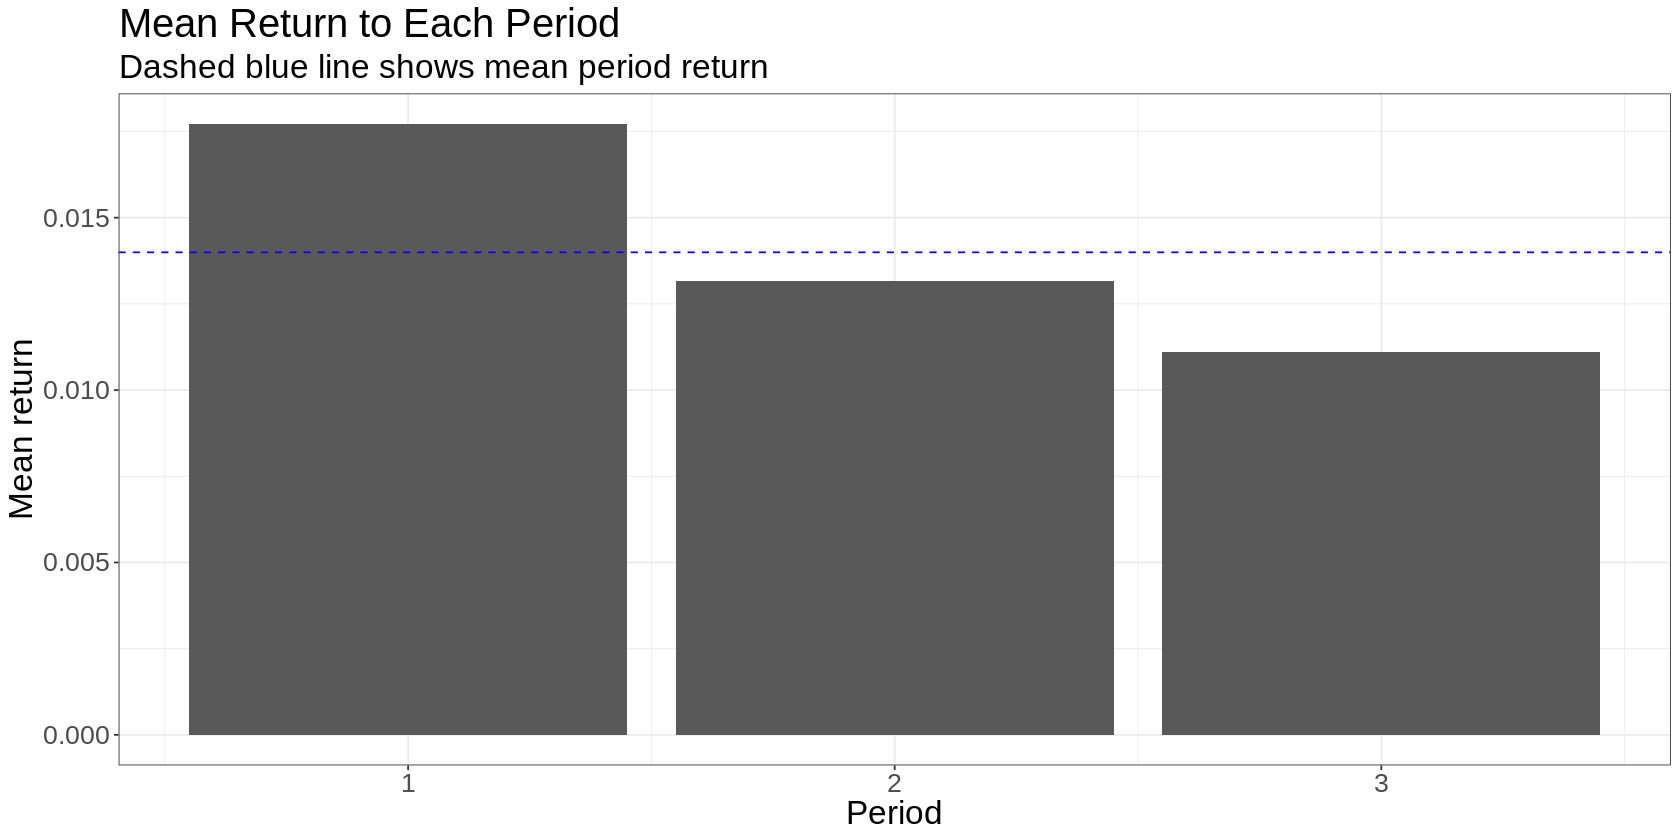

In [12]:
mean_period_return <- mean(aggregate_period_returns$mean_return)

aggregate_period_returns %>%
  ggplot(aes(x = period, y = mean_return)) +
    geom_bar(stat = "identity") +
    geom_hline(yintercept = mean_period_return, colour = "blue", linetype = "dashed") +
    labs(
      x= "Period",
      y = "Mean return",
      title = "Mean Return to Each Period",
      subtitle = "Dashed blue line shows mean period return"
    )


It does look like a big effect. And this approach to grouping our data captures the effect well.

## Simulating Thousands of Runs of History

Next we're going to randomly shuffle the order of our returns. This creates a new returns series with the same mean and standard deviation (a measure of volatility) as our original series, but with any time-series features (such as seasonality) that existed in the original data destroyed.

We'll do this a few thousand times and observe how frequently a seasonality comparable to that in our raw data arises by chance.

This is the same as asking the following question: *If we shuffle our data randomly, how often do we get a period return that exceeds the return to the periods in our raw data?*

Let's make some randomly shuffled returns series and look at the first few observations of several series:

In [13]:
# set a random seed so that we can replicate our results
set.seed(503)

# make a vector of log_returns for sampling from
log_returns <- tlt_trading_days %>% pull(log_return)

# shuffle returns n times

# replicate(n, expr, simplify = "array")
n <- 10000
shuffled_returns <- replicate(n, sample(log_returns, replace = FALSE))
colnames(shuffled_returns) <- as.character(1:n)

# print dimensions of our shuffled data - should have ~5000 rows and n columns
print(dim(shuffled_returns))

# show a few rows of the first few columns
shuffled_returns[1:8, 1:8]

[1]  3407 10000


1             2            3            4             5           
[1,]  0.0610001231  0.016435294 -0.006231367 -0.0060658349  0.009737079
[2,] -0.0241742960 -0.003363902 -0.001454386 -0.0567556598 -0.008373984
[3,]  0.0484447086  0.050171934  0.032337407  0.0462720068 -0.073665711
[4,]  0.0302778097  0.003616228 -0.016009712 -0.0254357635 -0.017368231
[5,] -0.0648839845 -0.090075634  0.015929472  0.0720141014  0.093474998
[6,]  0.0094790903 -0.027470994  0.010484628 -0.0333515397  0.003611141
[7,] -0.0011000319  0.042793319 -0.019617887  0.0009136166  0.003773586
[8,] -0.0009490512  0.036113107 -0.003418965  0.0023325386  0.038050126
     6            7            8           
[1,] -0.005883025  0.017188238  0.002319468
[2,] -0.014941645  0.003376507 -0.014229522
[3,]  0.001002809  0.000850158 -0.007566491
[4,]  0.011294601  0.006586553  0.006537416
[5,]  0.018987095  0.015667739 -0.001472212
[6,]  0.030862165  0.023515098  0.010934154
[7,]  0.009632021 -0.023010477  0.013123814
[8,] -0.014531934 -0.004632013  0.027144740



```
`# This is formatted as code`
```



Here's a plot of the first 500 randomly shuffled (returns aggregated through time) series to get a sense of how they behave:

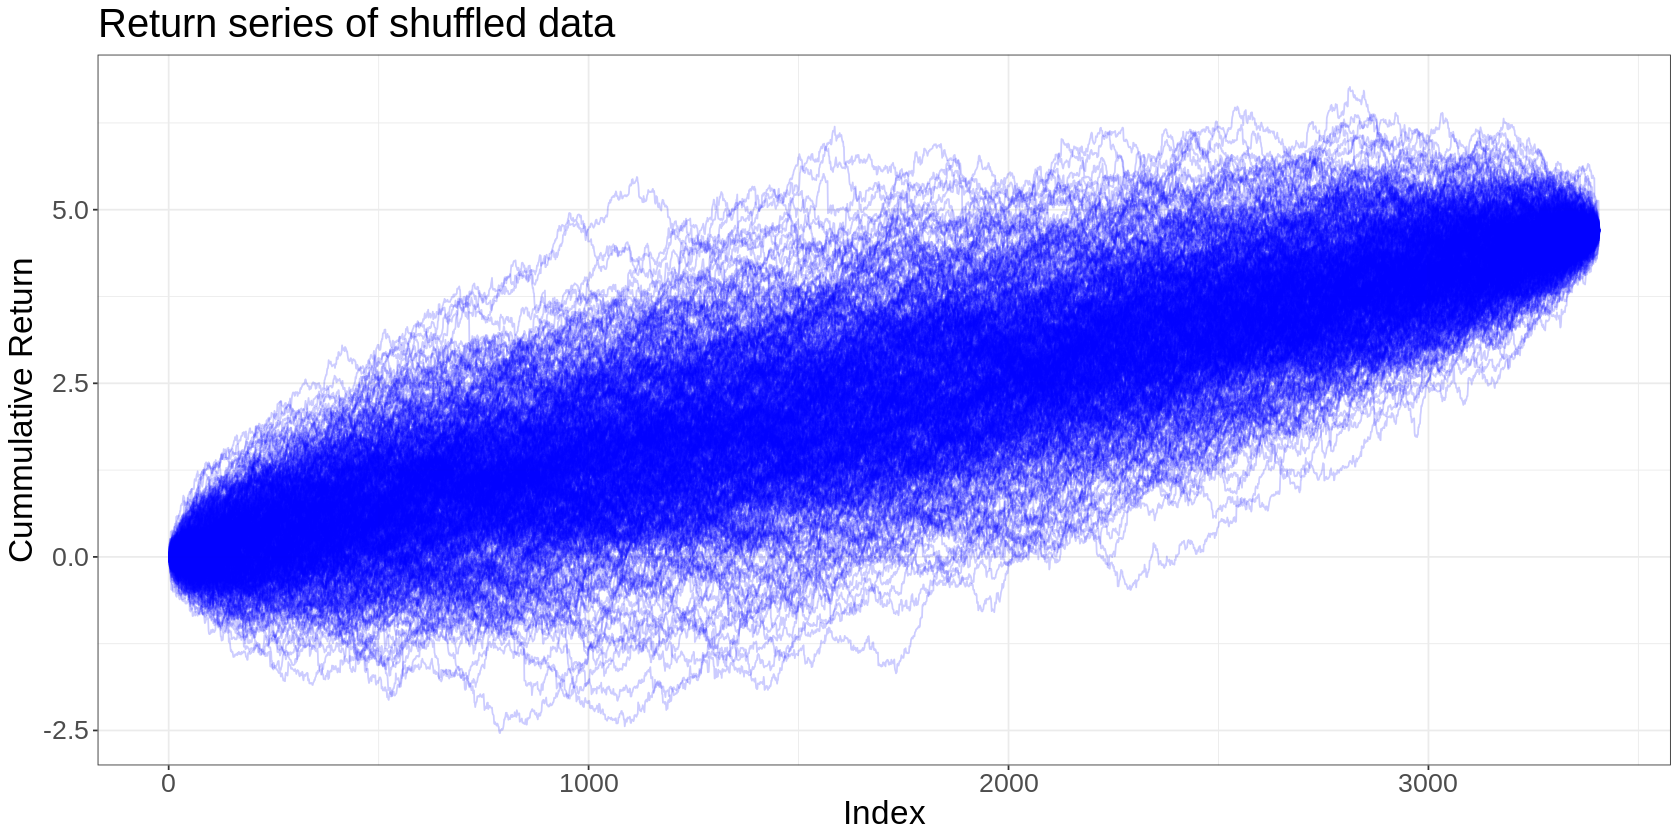

In [14]:
# plot 500 shuffled series to get a sense of how they behave
shuffled_returns[, 1:500] %>%
  apply(2, FUN = cumsum) %>%
  as_tibble() %>%
  mutate(index = row_number()) %>%
  pivot_longer(cols = -index, names_to = "series", values_to = "price") %>%
  ggplot(aes(x = index, y = price)) +
    geom_line(aes(group = series), colour = "blue", alpha = 0.2) +
    labs(
      x = "Index",
      y = "Cummulative Return",
      title = "Return series of shuffled data"
    )

You can see that they all end up at the same point - but they take different routes to arriving there.

Next, we'll make a dataframe from our shuffled returns that will enable further analysis.

This will give us a dataframe with the same number of observations (rows) as our actual data, but we'll have 10,000 shuffled price series in separate columns.

We can add the Date, year, month, and trading_day columns from our original data to our new dataframe to complete our shuffling operation.

Essentially, all we've done in this shuffling operation is randomly mixed up the order of our original returns:

In [15]:
shuffled_returns <- as_tibble(shuffled_returns) %>%
  # bind date, year, month, trading_dom from actual data - this completes our shuffling operation
  bind_cols(tlt_trading_days %>% select(Date, year, month, trading_dom))

# look at the first few price series
shuffled_returns %>%
  select(Date, year, month, trading_dom, 1:10) %>%
  head()

Date       year month trading_dom 1           2            3           
1 2014-10-02 2014 10    1            0.06100012  0.016435294 -0.006231367
2 2014-10-03 2014 10    2           -0.02417430 -0.003363902 -0.001454386
3 2014-10-04 2014 10    3            0.04844471  0.050171934  0.032337407
4 2014-10-05 2014 10    4            0.03027781  0.003616228 -0.016009712
5 2014-10-06 2014 10    5           -0.06488398 -0.090075634  0.015929472
6 2014-10-07 2014 10    6            0.00947909 -0.027470994  0.010484628
  4            5            6            7           8            9           
1 -0.006065835  0.009737079 -0.005883025 0.017188238  0.002319468  0.012687542
2 -0.056755660 -0.008373984 -0.014941645 0.003376507 -0.014229522  0.004566762
3  0.046272007 -0.073665711  0.001002809 0.000850158 -0.007566491 -0.068936107
4 -0.025435764 -0.017368231  0.011294601 0.006586553  0.006537416  0.006148589
5  0.072014101  0.093474998  0.018987095 0.015667739 -0.001472212 -0.020885561
6 -0.033351540  0.003611141  0.030862165 0.023515098  0.010934154 -0.030119733
  10          
1  0.026996838
2  0.037250082
3  0.064288419
4 -0.004089782
5  0.005358747
6 -0.017577793

Next we'll apply the operations we used on our raw data to our shuffled data:
- assign each trading day to a period (either 1, 2, or 3)
- sum returns to each monthly period (ie aggregate returns to 3 periods * 12 months * 20 years = ~720 individual period returns)
- for each shuffled series, collapse those ~720 period returns into the mean return to each period (ie end up with the 3 data points for each shuffled series = 30,000 total data points)

In [16]:
# these operations are quite slow when done using tidyverse functions... I think that's oK though because they're much more understandable this way.
# we could do more opaque matrix operations to speed things up at the expense of understanding what's going on.

# aggregate returns by period by column
shuffled_period_returns <- shuffled_returns %>%
  mutate(
    period = case_when(
      trading_dom <= 10 ~ 1,
      trading_dom >= 21 ~3,
      TRUE ~ 2
    )
  ) %>%
  group_by(year, month, period) %>%
  summarise(
    # this aggregates daily returns to total return to each monthly period in a column-wise fashion (ie preserves our shuffled series)
    across(.cols = c(-Date, -trading_dom), .fns = ~sum(.x), .names = "{.col}"),
    .groups = "drop"
  ) %>%
  group_by(period) %>%
  summarise(
    # this gets the mean return to each of the three periods for each shuffled series
    across(.cols = c(-year, -month), .fns = ~mean(.x), .names = "series_{.col}_mean_period_return")
  ) %>%
  ungroup()

# look at first few rows of first few columns
shuffled_period_returns %>% select(1:8) %>% head

period series_1_mean_period_return series_2_mean_period_return
1 1       0.039435407                0.01006564                 
2 2      -0.002692995                0.02812161                 
3 3       0.005241855                0.00379702                 
  series_3_mean_period_return series_4_mean_period_return
1 0.006112496                 0.023696723                
2 0.028277639                 0.001265328                
3 0.007594132                 0.017022216                
  series_5_mean_period_return series_6_mean_period_return
1 0.017679671                 0.013511571                
2 0.017108838                 0.020385050                
3 0.007195758                 0.008087646                
  series_7_mean_period_return
1 0.014133390                
2 0.005441432                
3 0.022409446

Next we'll compare our aggregated returns from our shuffled data with our actual data.

We'll plot the returns to our shuffled data as blue points overlain on bars representing the returns to our actual data.

To begin with, we'll just plot the shuffled data according to which period it happened to occur in (ie we'll plot the shuffled period 1 data over our actual period 1 return, the shuffled period 2 data over our actual period 2 return, and our shuffled period 3 data over our actual period 3 return).

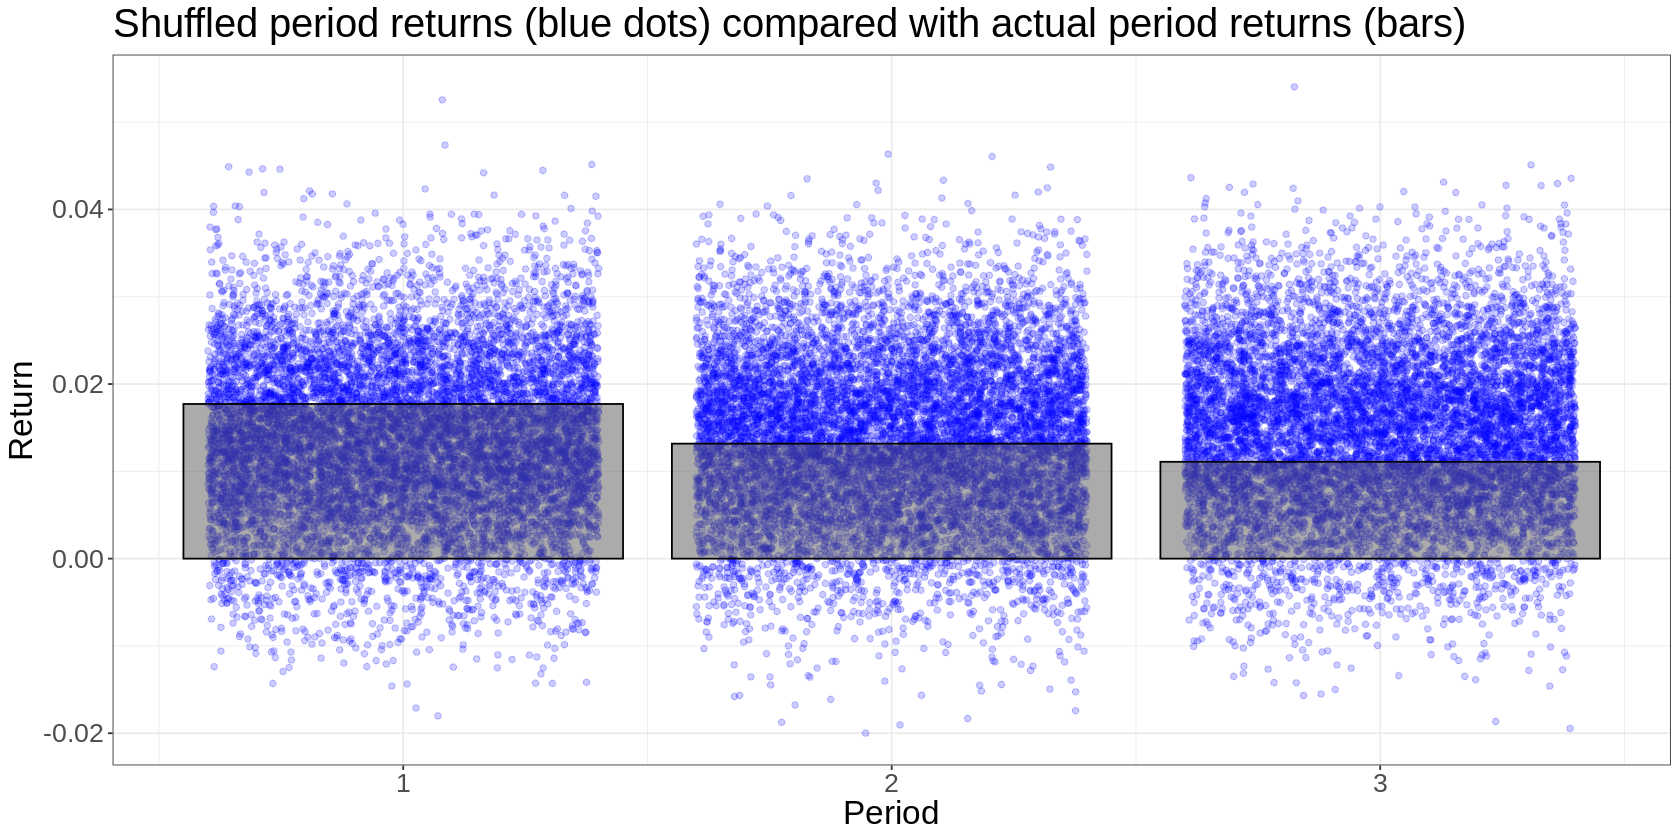

In [66]:
shuffled_period_returns %>%
  pivot_longer(-period, names_to = "series", values_to = "period_return") %>%
  ggplot(aes(x = period, y = period_return)) +
    # plot our shuffled data
    geom_point(aes(group = series), colour = "blue", alpha = 0.2, position = "jitter") +
    # plot our actual data
    geom_bar(data = aggregate_period_returns, aes(x = period, y = mean_return), colour = "black", alpha = 0.5, stat = "identity") +
    theme(legend.position = "none") +
    labs(
      x = "Period",
      y = "Return",
      title = "Shuffled period returns (blue dots) compared with actual period returns (bars)"
    )

Just from looking at the plot, you get the sense that our actual data is highly unusual in its non-randmonness:
- Rarely do we see a shuffled period 1 return as low as our actual period 1 return.
- Slightly more frequently, but still extrememly rarely, do we see a shuffled period 3 return as high as our actual period 3 return.
- Our period 2 return looks fairly typical.

We think there are good reasons for our actual data to look the way it does. Specifically, that period 1 returns should be low and period 3 returns high. So we might stop there and quantify some p-values based on what we've done so far.

But we can apply a slightly more stringent test to our data. We can ask "*what are the chances of seeing a return as low as our actual period 1 return regardless of where it occurs in the month?*"

Similarly "*what are the chances of seeing a return as high as our actual period 3 return regardless of where it occurs in the month?*"

To answer this slightly more conservative question, we can sort the period returns from each shuffled series from lowest to highest, and plot the lowest return over our period 1 return (the lowest return in our actual data), the middle return over our period 2 return (the middle return in our actual data), and the highest return over our period 3 return (the highest return in our actual data).

Essentially, we're allowing our shuffled returns to exhihbit returns of great magnitude at *any* of the three periods.

(We could go even further and look at the highest and lowest returns to *any* contiguous 7-day period within the month, but then we get into some complications around different numbers of observations in different groups... I don't think we need to go there - we get plenty of intuition about the randomness or otherwise of our acutal data as is).

Warning message:
“Removed 10000 rows containing missing values (`geom_point()`).”


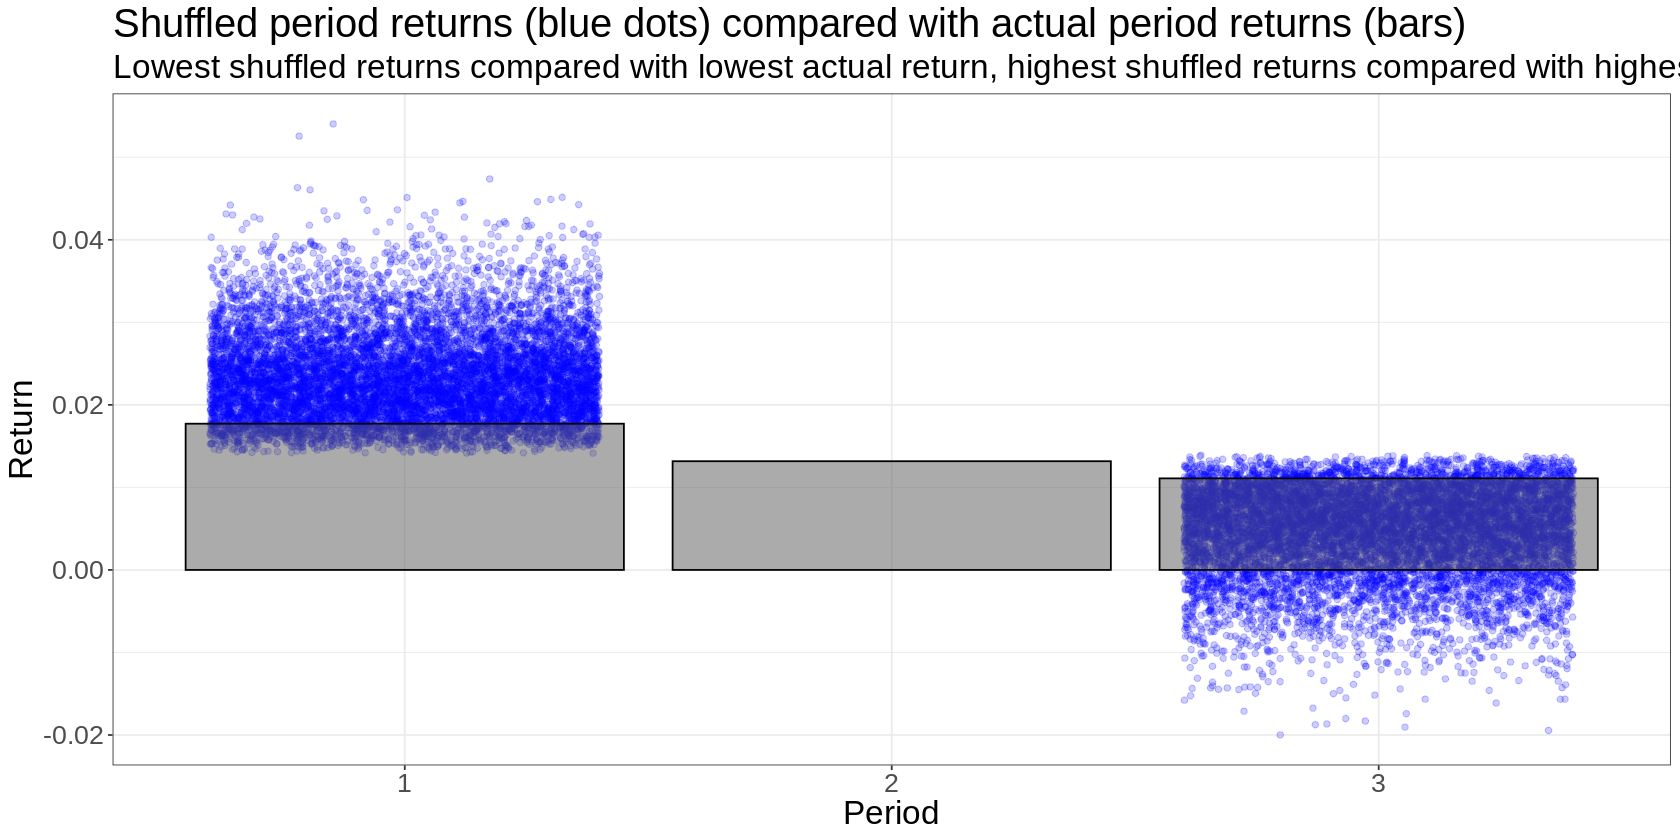

In [18]:
# this operation makes a long dataframe with the minimum period return of each
# series assigned to period 1, and the maximum to period 3. period 2 is omitted
unordered_shuffled_period_returns <- shuffled_period_returns %>%
  pivot_longer(-period, names_to = "series", values_to = "period_return") %>%
  group_by(series) %>%
  summarise(
   `3` = min(period_return),
   `1` = max(period_return)
  ) %>%
  mutate(`2` = NA)

unordered_shuffled_period_returns  %>%
  pivot_longer(-series, names_to = "period", values_to = "period_return") %>%
  ggplot(aes(x = period, y = period_return)) +
    # plot our shuffled data
    geom_point(aes(group = series), colour = "blue", alpha = 0.2, position = "jitter") +
    # plot our actual data
    geom_bar(data = aggregate_period_returns, aes(x = period, y = mean_return), colour = "black", alpha = 0.5, stat = "identity") +
    theme(legend.position = "none") +
    labs(
      x = "Period",
      y = "Return",
      title = "Shuffled period returns (blue dots) compared with actual period returns (bars)",
      subtitle = "Lowest shuffled returns compared with lowest actual return, highest shuffled returns compared with highest actual return"
    )

We can see that none of our shuffled price curves exhibit a mean period return as low as the mean return to period 1 in our actual data!

We can see that only a handful of our shuffled price curves exhibit a mean period return as high as the mean return to period 3 in our data.

(The middle period return was omitted from our shuffled data in the plot above)

It's also illustrative to view the above data in histogram format. These historgrams show where our actual data lie on the distribution of our shuffled data:

In [19]:
# distribution of maximum period returns in shuffled data

min_max_shuffled_returns <- shuffled_period_returns %>%
  # get max and min mean period return for each series
  pivot_longer(-period, names_to = "series", values_to = "period_return") %>%
  group_by(series) %>%
  summarise(
    highest_return = max(period_return),
    lowest_return = min(period_return)
  )

min_max_shuffled_returns %>% head()

series                          highest_return lowest_return
1 series_10000_mean_period_return 0.02428239     0.007102324  
2 series_1000_mean_period_return  0.01971197     0.005892685  
3 series_1001_mean_period_return  0.02796110     0.005223696  
4 series_1002_mean_period_return  0.01642226     0.010456718  
5 series_1003_mean_period_return  0.01929598     0.004232764  
6 series_1004_mean_period_return  0.01625439     0.012626730

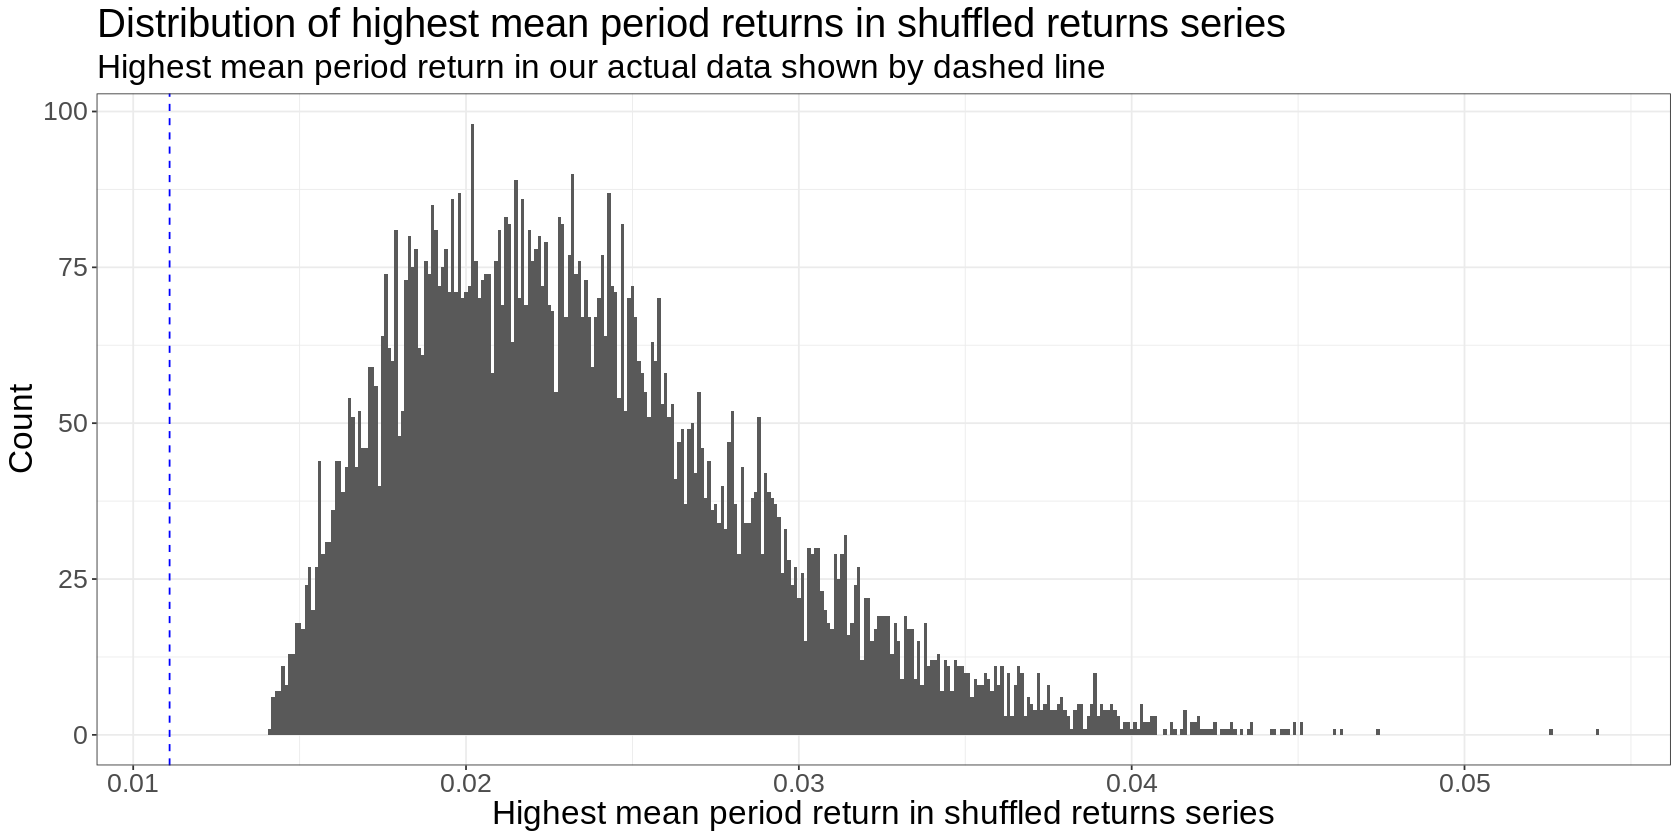

In [20]:
actual_highest_return <- aggregate_period_returns$mean_return[3]

min_max_shuffled_returns %>%
  ggplot(aes(x = highest_return)) +
    geom_histogram(binwidth = 0.0001) +
    geom_vline(xintercept = actual_highest_return, colour = "blue", linetype = "dashed") +
    labs(
      x = "Highest mean period return in shuffled returns series",
      y = "Count",
      title = "Distribution of highest mean period returns in shuffled returns series",
      subtitle = "Highest mean period return in our actual data shown by dashed line"
    )

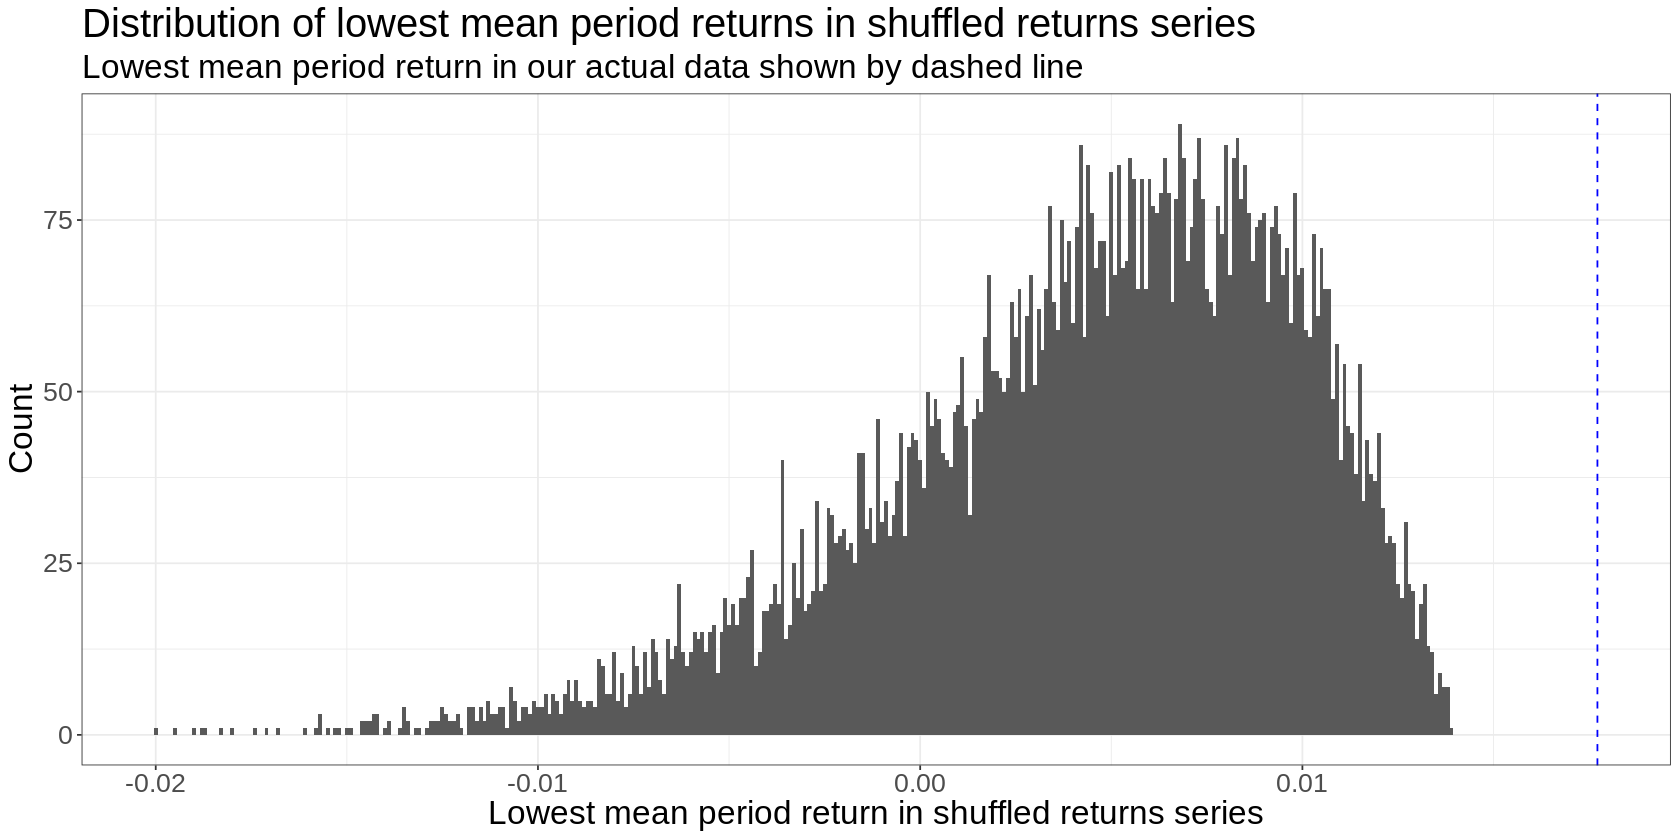

In [21]:
actual_lowest_return <- aggregate_period_returns$mean_return[1]

min_max_shuffled_returns %>%
  ggplot(aes(x = lowest_return)) +
    geom_histogram(binwidth = 0.0001) +
    geom_vline(xintercept = actual_lowest_return, colour = "blue", linetype = "dashed") +
    labs(
      x = "Lowest mean period return in shuffled returns series",
      y = "Count",
      title = "Distribution of lowest mean period returns in shuffled returns series",
      subtitle = "Lowest mean period return in our actual data shown by dashed line"
    )

But let's now quantify what we see in the plots above by calculating some p-values. We do this by counting the number of times our shuffled data is more or equally extreme as our actual data:



In [22]:
# for each period, how many shuffled price curves resulted in a seasonality effect greater than our actual data?

min_max_shuffled_returns %>%
  # replace value with 1/0 if >/< actual return
  # maybe rename columns 1 and 3... getting a bit confusing
  mutate(exceeds_lowest_actual_return = case_when(lowest_return <= actual_lowest_return ~ 1, TRUE ~ 0)) %>%
  mutate(exceeds_highest_actual_return = case_when(highest_return >= actual_highest_return ~ 1, TRUE ~ 0)) %>%
  summarise(
    pval_lowest = sum(exceeds_lowest_actual_return)/n,
    pval_highest = sum(exceeds_highest_actual_return)/n
  )


pval_lowest pval_highest
1 1           1

Our p-values are 0 and 0.003!

That is, the chances of our lowest return arising by chance is zero. And the chance of our highest return arising by chance is 0.3%.

Of course, our p-value for exceeding our lowest return isn't actually zero. Rather, we simply didn't get a single value in 10,000 random tries. So it's pretty close to zero!

We can interpret this as there being almost no chance that our actual data looks the way it does by chance.

## Example 2: "I won't trade anything with a Sharpe less than 0.4"

If I won't trade something with Sharpe 0.4, how many observations do I need to be about 80% confidant that what I'm trading does indeed have a Sharpe of at least 0.4?

To answer this question through simulation, we could simulate a bunch of random price paths with the same mean, volatility, and trade frequency of our strategy. We could then calculate how many of these random price paths with known Sharpe actually realised a Sharpe of at least 0.4 at any point in time.

We'll use the following assumptions:
- Our actual strategy has a Sharpe of 1.0 (but in reality we can't actually know this)
- We'll use daily returns, since this is the frequency at which most part-time traders will tend to rebalance
- We'll use a [Geometric Brownian Motion](https://en.wikipedia.org/wiki/Geometric_Brownian_motion) (GBM) simulator to make returns that look roughly like stock index returns.


First, here are some functions for making sets of GBM price paths, converting them into a long dataframe format, and plotting a slection of them:





In [23]:
# GBM simulator
gbm_sim <- function(nsim = 100, t = 30, mu = 0, sigma = 0.1, S0 = 100, dt = 1./365) {

  # matrix of random draws - one for each day for each simulation
  epsilon <- matrix(rnorm(t*nsim), ncol = nsim, nrow = t)

  # get GBM paths
  gbm <- exp((mu - sigma * sigma / 2) * dt + sigma * epsilon * sqrt(dt))

  return(apply(rbind(rep(S0, nsim), gbm), 2, cumprod))
}

# convert matrix of GBM prices to long dataframe
make_long_gbm_prices_df <- function(gbm_matrix) {

  long_df <-  gbm_matrix %>%
    as.data.frame(gbm_matrix) %>%
    mutate(ix = 0:(nrow(gbm_matrix)-1)) %>%
    pivot_longer(-ix, names_to = 'sim', values_to = 'price')

  return(long_df)
}

# plot a selection of GBM price paths
prices_plot <- function(gbm_long_df, thin_paths_factor = 1) {

  if(thin_paths_factor > 1) {
    sims_to_plot <- paste0("V", seq(1, n_distinct(gbm_long_df$sim), by = thin_paths_factor))

    p <- gbm_long_df %>%
      filter(sim %in% sims_to_plot) %>%
      ggplot(aes(x=ix, y=price, colour = sim)) +
      geom_line(alpha = 0.6) +
      labs(
        x = 'Days',
        y = "Value",
        title = "Selection of simulated strategy equity curves"
      ) +
      theme(legend.position = 'none')

    return(p)
  } else {
    p <- gbm_long_df %>%
      ggplot(aes(x=ix, y=price, colour = sim)) +
      geom_line(alpha = 0.6) +
      labs(
        x = 'Days',
        y = "Value",
        title = "Selection of simulated strategy equity curves"
      ) +
      theme(legend.position = 'none')

    return(p)
  }
}

Here we create our simulated strategy equity curves.

Our strategies are constructed with a Sharpe of 1.0, but since they're generated using a random process, they'll only converge to this Sharpe in the limit. Over any finite chunk of history, they can show deviation from this value.

How much are they likely to deviate?

We'll construct 1000 equity curves (I'd ideally like to use more, but some of the operations we need to do are a bit intense), and we'll simulate 1500 days (around 6 years) of daily trades.

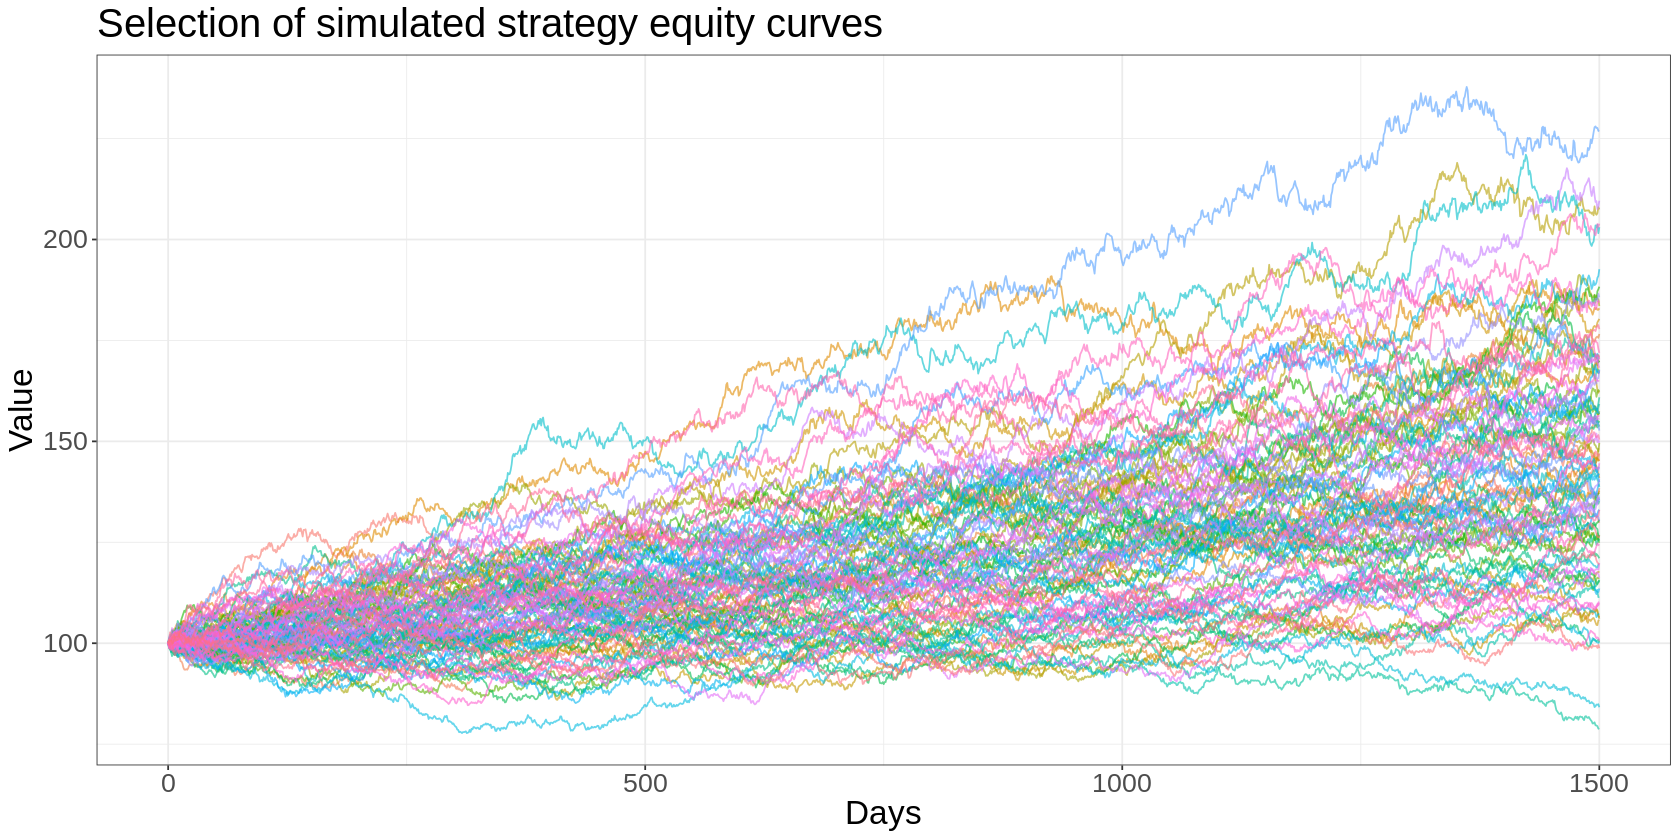

In [24]:
# set up sharpe 1.0 characteristics
mean_return <- 0.10
vol <- mean_return/1.0
n <- 1000  # number of simulations
sim_length <- 1500

prices <- gbm_sim(nsim = n, t = sim_length, mu = mean_return, sigma = vol)

# head(prices[1:5, ])

prices_long <- prices %>%
  make_long_gbm_prices_df()

prices_long %>%
  prices_plot(thin_paths_factor = 10)


From the plot above, it's apparent that our Sharpe 1 strategy could conceivably produce an immense range of outcomes over a finite chunk of history.

Next, we'll quantify this range by plotting the distribution of the realised Sharpes of the simulated straetgies on the last day of the simulation:

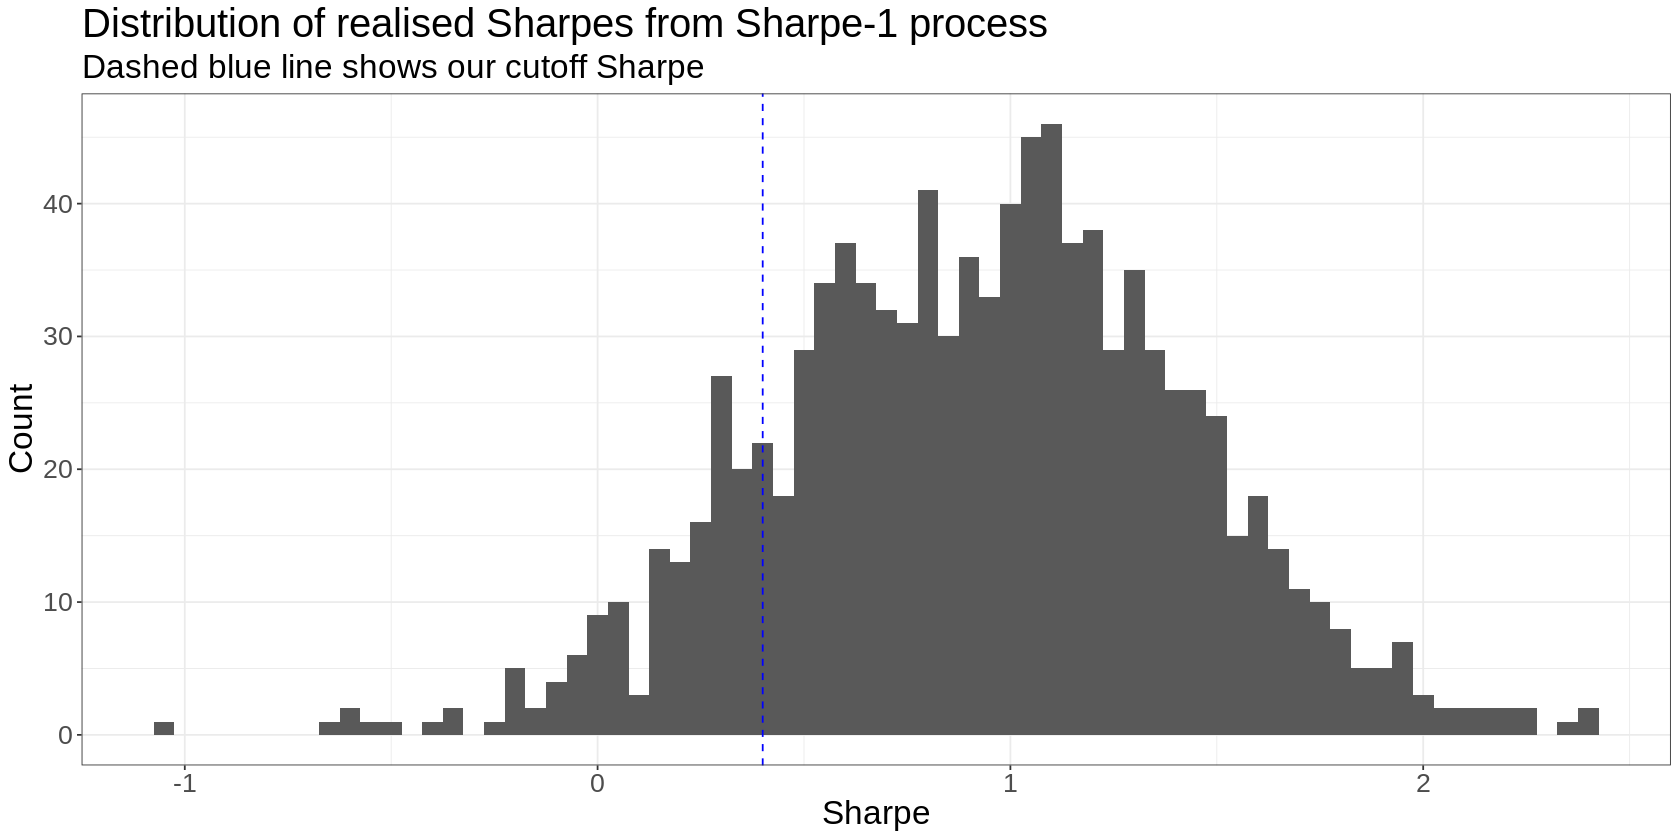

In [25]:
# distribution of realised sharpe of n random series of sharpe 1 after sim_length days
sharpe <- function(x) {
  sqrt(365)*mean(x)/sd(x)
}

sharpes <- prices_long %>%
  group_by(sim) %>%
  mutate(returns = log(price/dplyr::lag(price))) %>%
  na.omit() %>%
  summarise(
    sharpe = sharpe(returns)
  )

cutoff <- 0.4

sharpes %>%
  ggplot(aes(x = sharpe)) +
    geom_histogram(binwidth = 0.05) +
    geom_vline(xintercept = cutoff, colour = "blue", linetype = "dashed") +
    labs(
      x = "Sharpe",
      y = "Count",
      title = "Distribution of realised Sharpes from Sharpe-1 process",
      subtitle = "Dashed blue line shows our cutoff Sharpe"
    )

How confidant could we be, after 1500 days, that our strategy (that actually has a Sharpe of 1, but we don't know this) has a Sharpe of at least 0.4?

In [26]:
sharpes %>%
  mutate(exceeds_cutoff = case_when(sharpe >= cutoff ~ 1, TRUE ~ 0)) %>%
  summarise(pval = sum(exceeds_cutoff)/n)

pval 
1 0.852

We could be 84% confidant that our strategy had a Sharpe of at least 0.4 after 6 years of trading!

Note: technically our p-value here would be 1 minus the p-value we've used above, which would be in line with the null hypothesis that our strategy has a Sharpe of less than 0.4 (ie *what is the chance that our strategy realised a Sharpe of less than 0.4 by chance alone*) - but I think what we've done here is easier to reason about.

In the next part, we'll answer the question of roughly how much data we actually need to be 80% confidant that our Sharpe 1 strategy is at least a Sharpe 0.4 strategy.

We'll do this by calculating a rolling sharpe for each simulated equity curve using an expanding window. Then, we'll calculate a p-value for each day in our simulation that tells us the proportion of our simulated strategies that have a realised Sharpe of at least 0.4 on any given day.

We'll need a function from the `zoo` library:

In [27]:
install.packages("zoo")
library(zoo)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [28]:
# calculate returns from prices matrix
# work with matrix as quicker... still takes a while though
returns <- diff(log(prices))

# calculate rolling sharpes
roll_sharpes <- rollapply(returns, width = 1:nrow(returns), FUN = sharpe, align = "right", fill = NA, by.column = TRUE)  # using an expanding width gives us an expanding window
head(roll_sharpes)

[,1]      [,2]      [,3]      [,4]       [,5]     [,6]       [,7]     
[1,]        NA        NA        NA         NA       NA         NA        NA
[2,]  7.249952 -18.36107 84.413199 -31.414505 46.40358  0.2442908  6.011884
[3,] 15.011645 -10.55762 20.427502 -45.703231 44.84406  9.1422131 11.954896
[4,]  7.373338 -12.33874  4.786314 -23.470550 24.35744 14.5168382  6.831386
[5,] 11.785228 -14.04068  5.890652  -1.295005 27.46654  7.4633412 11.436216
[6,]  5.209270 -15.59463  8.856532  -6.437828 30.79325  6.0996708 14.867538
     [,8]     [,9]       [,10]     [,11] [,12]       [,13]       [,14]     
[1,]       NA         NA        NA ⋯              NA          NA         NA
[2,] 9.218374 18.2788318 -1.093115 ⋯     231.7005937   0.3927896 -11.430468
[3,] 2.759648 -0.6317219  2.023429 ⋯      26.1195643   0.8284141 -13.718227
[4,] 3.715604  2.0098060 -6.280900 ⋯       8.0533375  -7.0673391 -13.841710
[5,] 8.235887  0.1804166  1.146772 ⋯       0.5290237 -10.9363021  -5.589647
[6,] 6.690227  2.8718024 -1.087589 ⋯       6.2937943 -13.5483184  -9.541040
     [,15]      [,16]      [,17]      [,18]     [,19]      [,20]      [,21]    
[1,]         NA         NA         NA        NA         NA         NA        NA
[2,] -0.3667199 -69.242433 -217.95143 -5.246557 -12.826385  9.9444386 -2.116222
[3,]  1.2951415 -14.900638  -33.95429 -2.790613 -12.818837 -0.8164538  6.072720
[4,] -0.9688132  -7.917181  -29.06781  3.360351 -17.541135  1.8213779  2.840942
[5,]  1.7603971  -5.207251  -10.51479  5.808347  -2.455271 -2.0713804  2.565376
[6,]  5.7720621  -1.109860  -13.07842 -1.180023   5.385760 -3.1328592 -2.521245

Next we'll plot the evolution of the realised Sharpe for a selection of our simulated price paths:

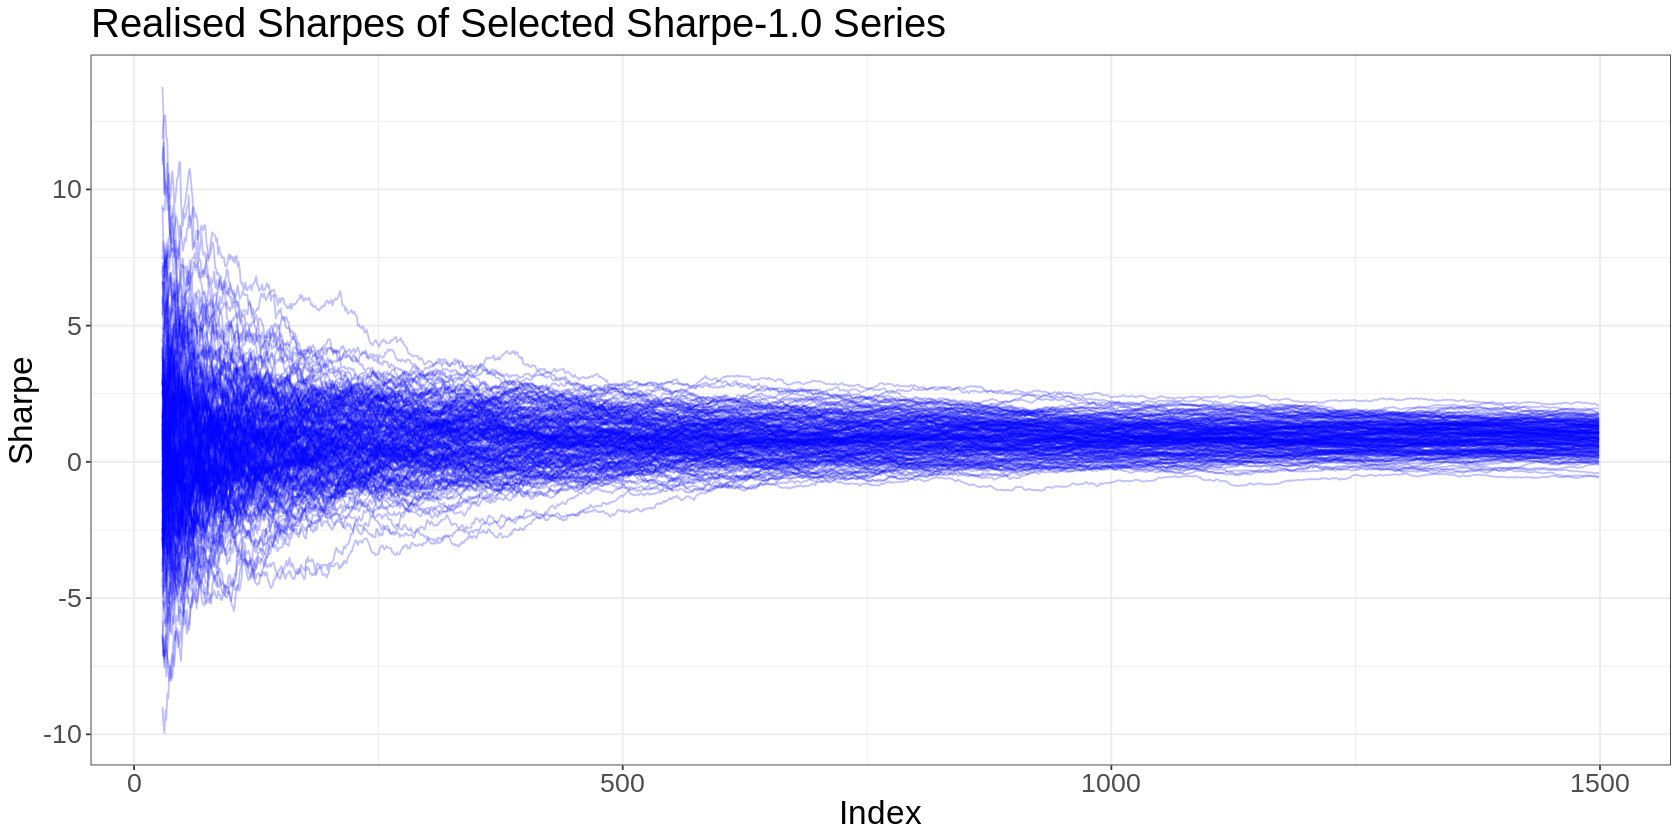

In [29]:
# turn into a dataframe and plot a selection of expanding window sharpes
roll_sharpes_long <- roll_sharpes %>%
  as_tibble(.name_repair = ~ glue("V{1:ncol(roll_sharpes)}")) %>%
  na.omit() %>%
  mutate(index = row_number()) %>%
  filter(index >= 29) %>%  # have at least 20 days before calculating a Sharpe
  pivot_longer(-index, names_to = "series", values_to = "sharpe")

sims_to_plot <- paste0("V", seq(1, n_distinct(roll_sharpes_long$series), by = 5))

roll_sharpes_long %>%
  filter(series %in% sims_to_plot) %>%
  ggplot(aes(x = index, y = sharpe, group = series)) +
    geom_line(colour = "blue", alpha = 0.25) +
    theme(legend.position = "none") +
    labs(
      x = "Index",
      y = "Sharpe",
      title = "Realised Sharpes of Selected Sharpe-1.0 Series"
    )

**TODO**: plot the actual sharpe as a horizontal line above

You can see that as time goes on, the realised Sharpes start converging on the actual Sharpe of our strategy. But you can also see that after some initial rapid convergence, things slow down quite dramatically.

We can quantify this by calculting our p-value for each day in our simulation and plotting:

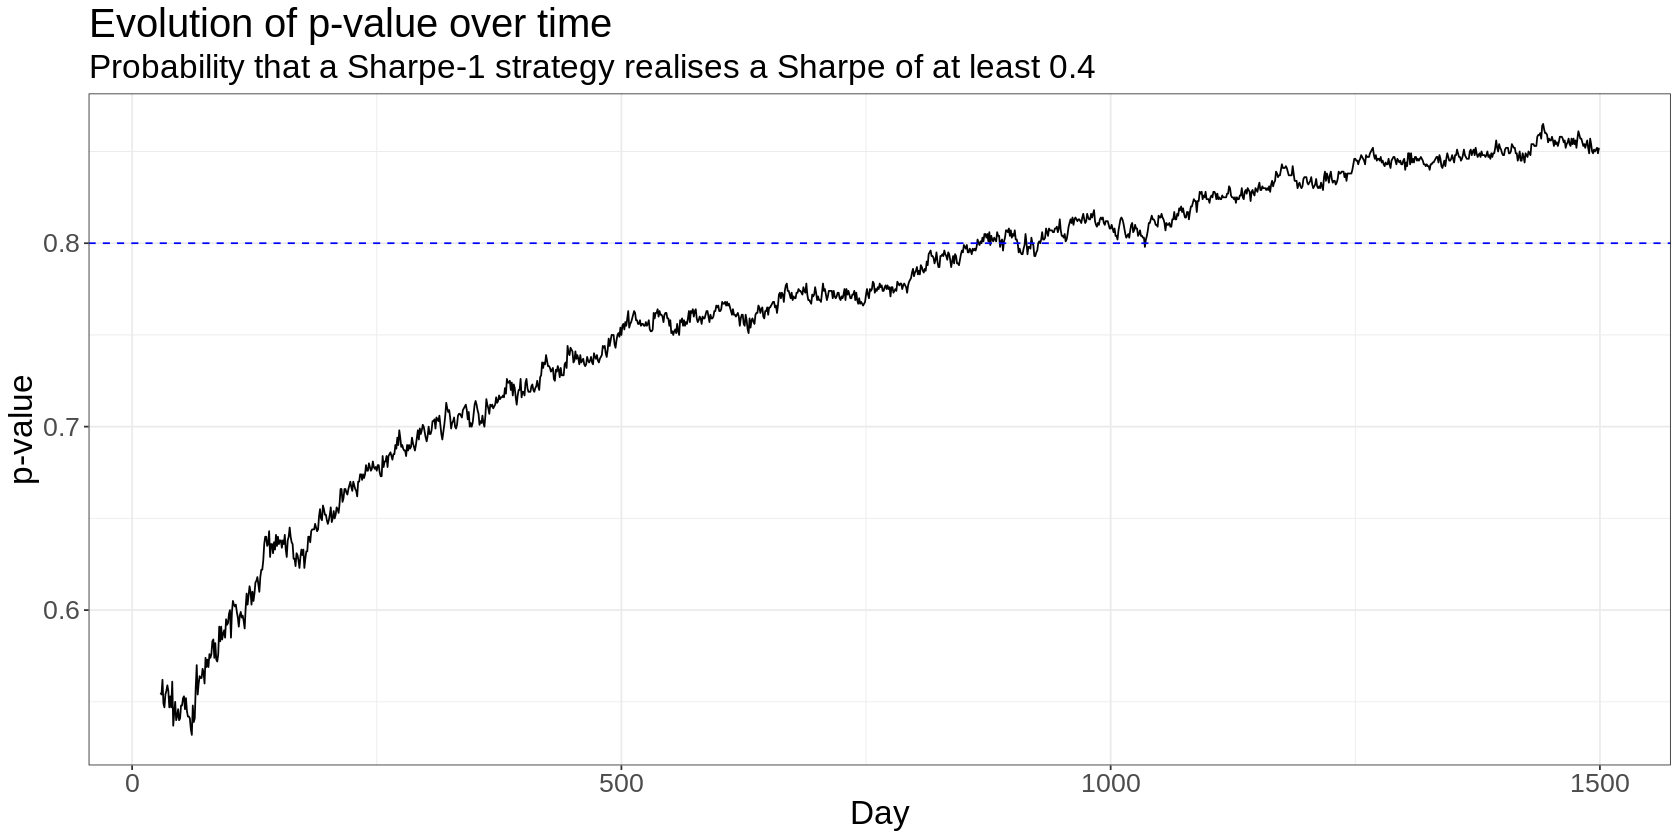

In [30]:
# calculate rolling p-values
# for each day, sum the number of sims whose rolling sharpe is greater than our minimum
# maybe better to do this operation in a long dataframe
roll_sharpes_long %>%
  mutate(exceeds_cutoff = case_when(sharpe >= cutoff ~ 1, TRUE ~ 0)) %>%
  group_by(index) %>%
  summarise(
  p_val = sum(exceeds_cutoff)/ncol(roll_sharpes)
  ) %>%
  ggplot(aes(x = index, y = p_val)) +
    geom_line() +
    geom_hline(yintercept = 0.8, colour = "blue", linetype = "dashed") +
    labs(
      x = "Day",
      y = "p-value",
      title = "Evolution of p-value over time",
      subtitle = "Probability that a Sharpe-1 strategy realises a Sharpe of at least 0.4"
    )

You can see that our p-value pokes above 80% around the 950-day mark, and stays above it from about day 1,000.

I hope this gives you some insight about just how much data you need to say much of anything about a low-frequency trading strategy!

(Technically, our p-value would be one minus what we're calling our p-value (ie the probability that our Sharpe-1 strategy realised a Sharpe of less than 0.4 by chance - in line with the null hypothesis that the strategy has a Sharpe of less than 0.4) - but I think what we've done here is easier to reason about.)

Now, unfortunately, what I've just shown you isn't as useful as you might think.

Whenever we build a strategy, we're inevitably biasing it in ways we can't account for (even if that's just looking at something that others snooped at and therefore subjected to selection bias).

So my throwaway line above about the actual Sharpe of our strategy being unknowable becomes an important consideration.

What if the strategy that backtested to Sharpe 1 was destined for a long-run Sharpe of 0.5? It would still meet our criteria for portfolio inclusion, but we'd need a ton more trading days to say anything sensible about it.

The good news is that there are practical ways to close this uncertainty a little. And they have nothing to do with statistics.

Number 1 is that the strategy itself should make sense. There should be a good story that you can frame in terms of a structural effect, behavioural observation, or some other real and logical reason for the effect you're harnessing to exist. As you can see above, you don't want to be solely dependent on your trading returns to provide insight into whether you should be trading something! You'd need to trade it for years before you could really say anything.

Number 2 is that you want to see some consistency in the effect: it should show up roughly similarly in discrete chunks of your historical data, as well as in other places you'd expect it to (similar assets or asset classes, for instance). Of course, you rarely see perfect and obvious consistency across these dimensions, but you ideally want to be able to observe it noisily and on average.

## Example 3: Under what circumstances would stopping rules increase expected returns?

Under what circumstances would trend-following / stopping rules increase expected returns?

How you can use simulation to reason about strategy rule design?


Start with random draws from a normal distribution constructed to have a certain long-run Sharpe.

First, do a long simulation (high n) so that we can check that the returns converge to the constructed Sharpe in the limit

In [31]:
# construct large normally distributed returns series with Sharpe 0.5 (S&P-like)
sharpe <- 0.5
ann_return <- 0.1
mean_daily_return <- ann_return/365
vol <- sqrt(365) * mean_daily_return/sharpe

days <- 10000000
returns <- rnorm(days, mean_daily_return, vol)

# check sharpe
sqrt(365) * mean(returns)/sd(returns)

[1] 0.5056494

Our realised Sharpe is close to the Sharpe we intended to construct. This is simply a check that we're not doing anything silly in how we construct our random process.

Next, we construct a shorter series (so that it's easier to work with) and plot the cumulative return curve and the return historgram:

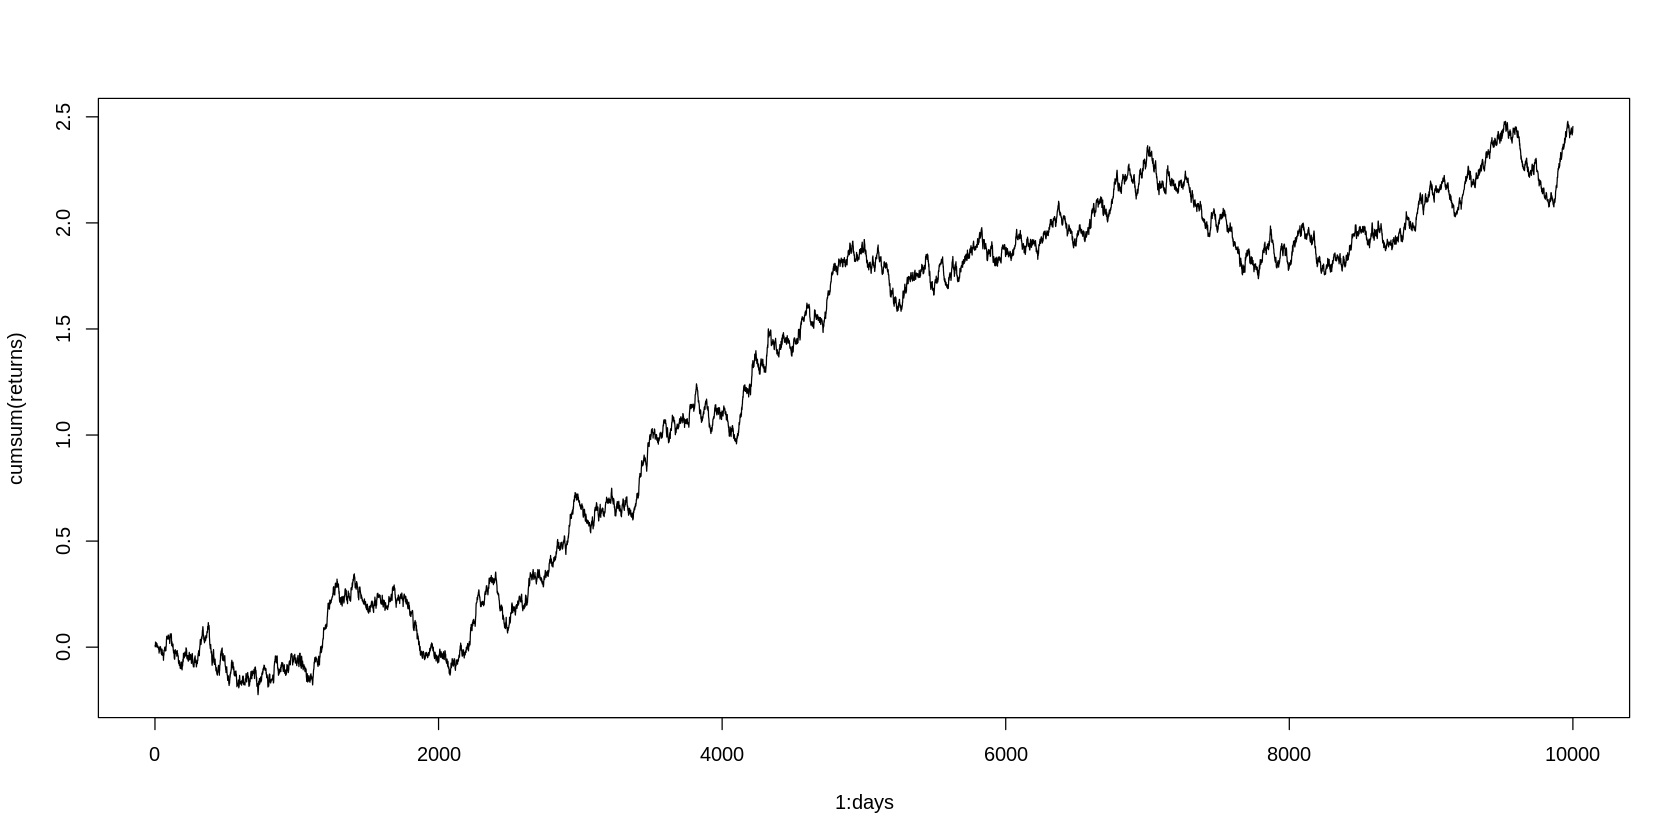

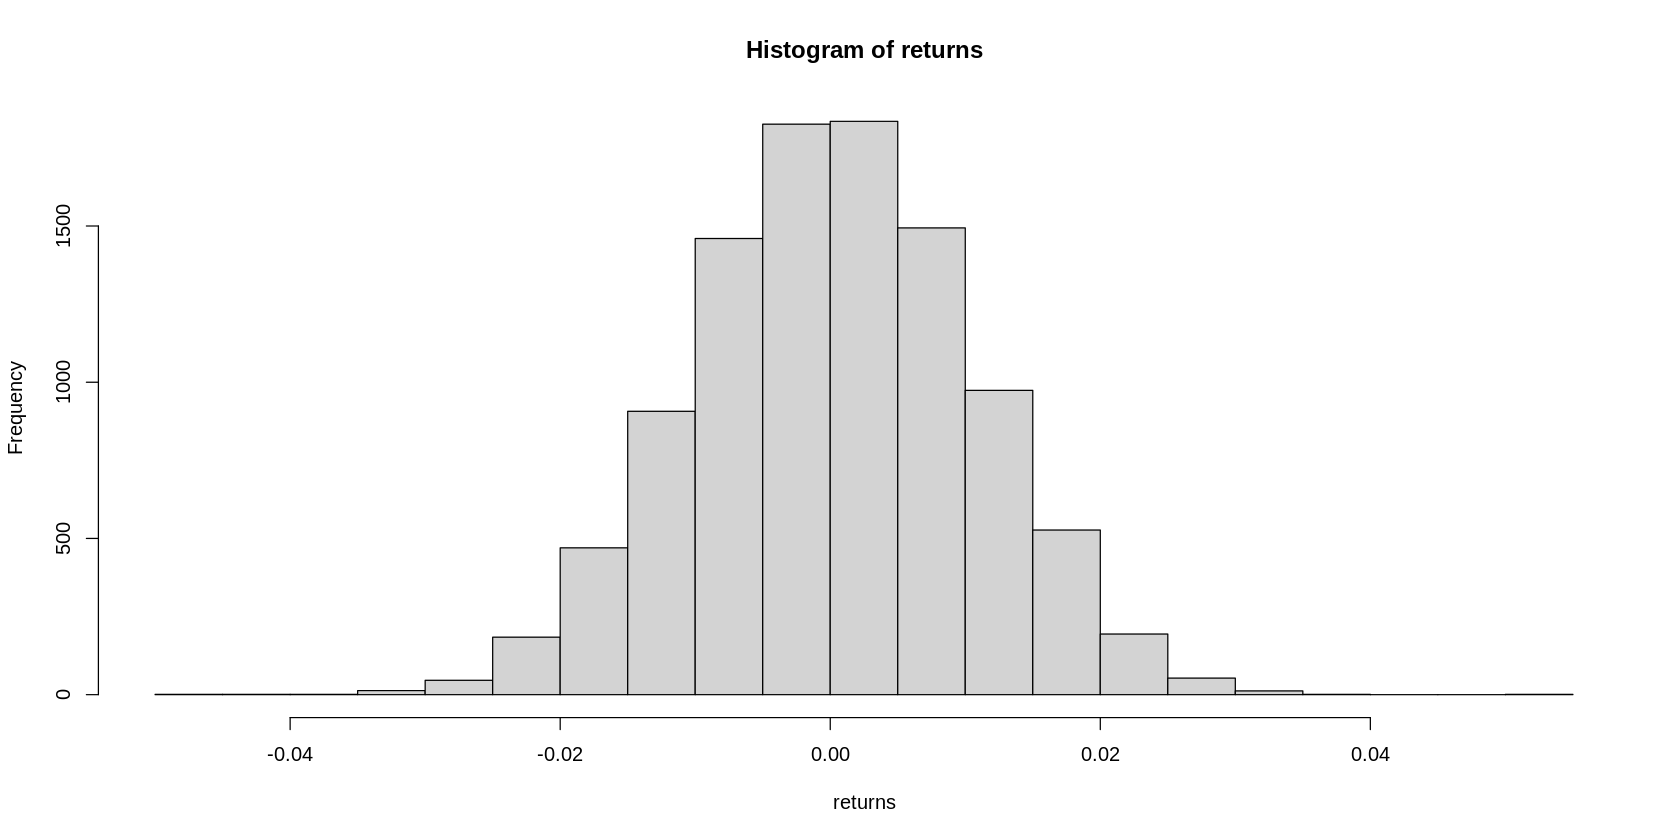

In [32]:
# plot price curve
days <- 10000
returns <- rnorm(days, mean_daily_return, vol)

plot(1:days, cumsum(returns), type = 'l')

# plot distribution of returns
hist(returns, breaks = 20)

In [33]:
# which approach?
# install.packages("microbenchmark")
# library(microbenchmark)

# set.seed(1)

# microbenchmark(
#   base = pmin(which(dd < -0.15) + 1, days),
#   tidy = dplyr::lag(which(dd < -0.15)),
#   times = 10
# ) %>%
#   group_by(expr) %>%
#   summarise(ave = mean(time))

Our base case strategy consists of simply being long only, all the time (which is not a crazy strategy when you have confidence in a long-run, but hard-to-predict positive expectancy... risk premia anyone?)

We'll make a strategy that tactically trades the price curve based on some stopping criterion, and then compare this to the base case.

The stopping criterion is:
- Stop trading if the strategy drawdown exceeds x% (ie underlying is down x%)
- Restart trading when the underlying comes out of its drawdown (ie makes new ATH)

In [34]:
dd_limit <- -0.1  # drawdown limit - stopping criterion

# create strategy rules
strat_returns <- returns
# add stopping rule - calculate drawdown... do vectorised for performance later
dd <- cumsum(returns) - cummax(cumsum(returns))
strat_returns[pmin(which(dd < dd_limit)+1, days)] = 0  # simple vectorised version that lags the drawdown signal

# compare sharpes
base_case_sharpe <- sqrt(365) * mean(returns)/sd(returns)
strategy_sharpe <- sqrt(365) * mean(strat_returns)/sd(strat_returns)
print(glue(
  "Sharpe of long-only-all-the-time strategy: {round(base_case_sharpe, 2)}
  Sharpe of tactically long strategy: {round(strategy_sharpe, 2)}"
))

Sharpe of long-only-all-the-time strategy: 0.45
Sharpe of tactically long strategy: 0.26


Interesting... in this particular realisation of history, the stopping rule reduced the Sharpe of our strategy.

Let's plot the cumulative returns to the base case and the strategy, and their return histograms:

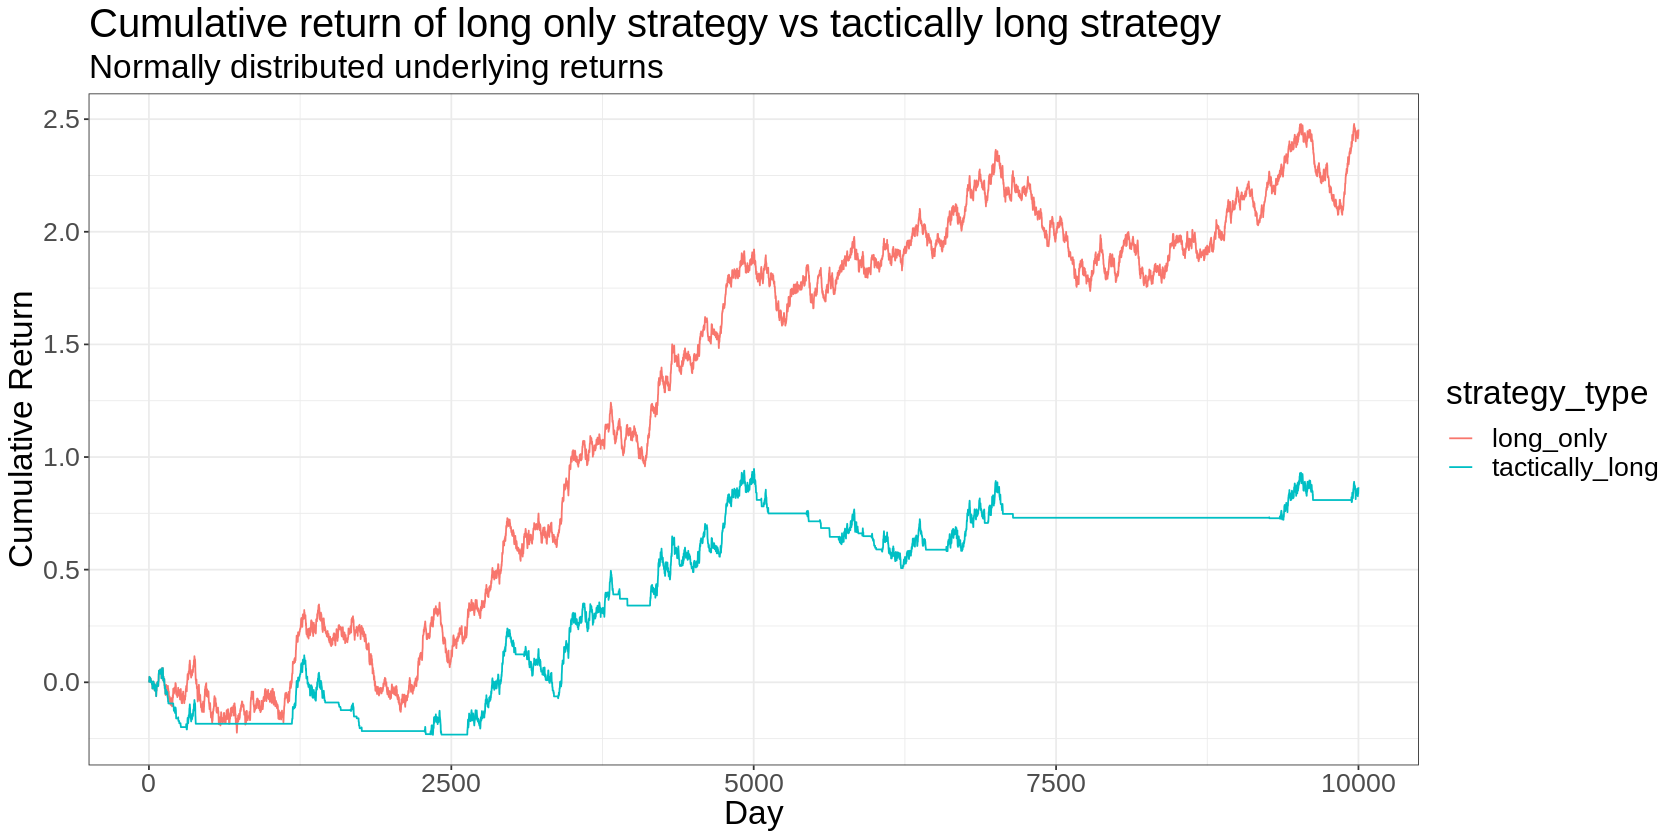

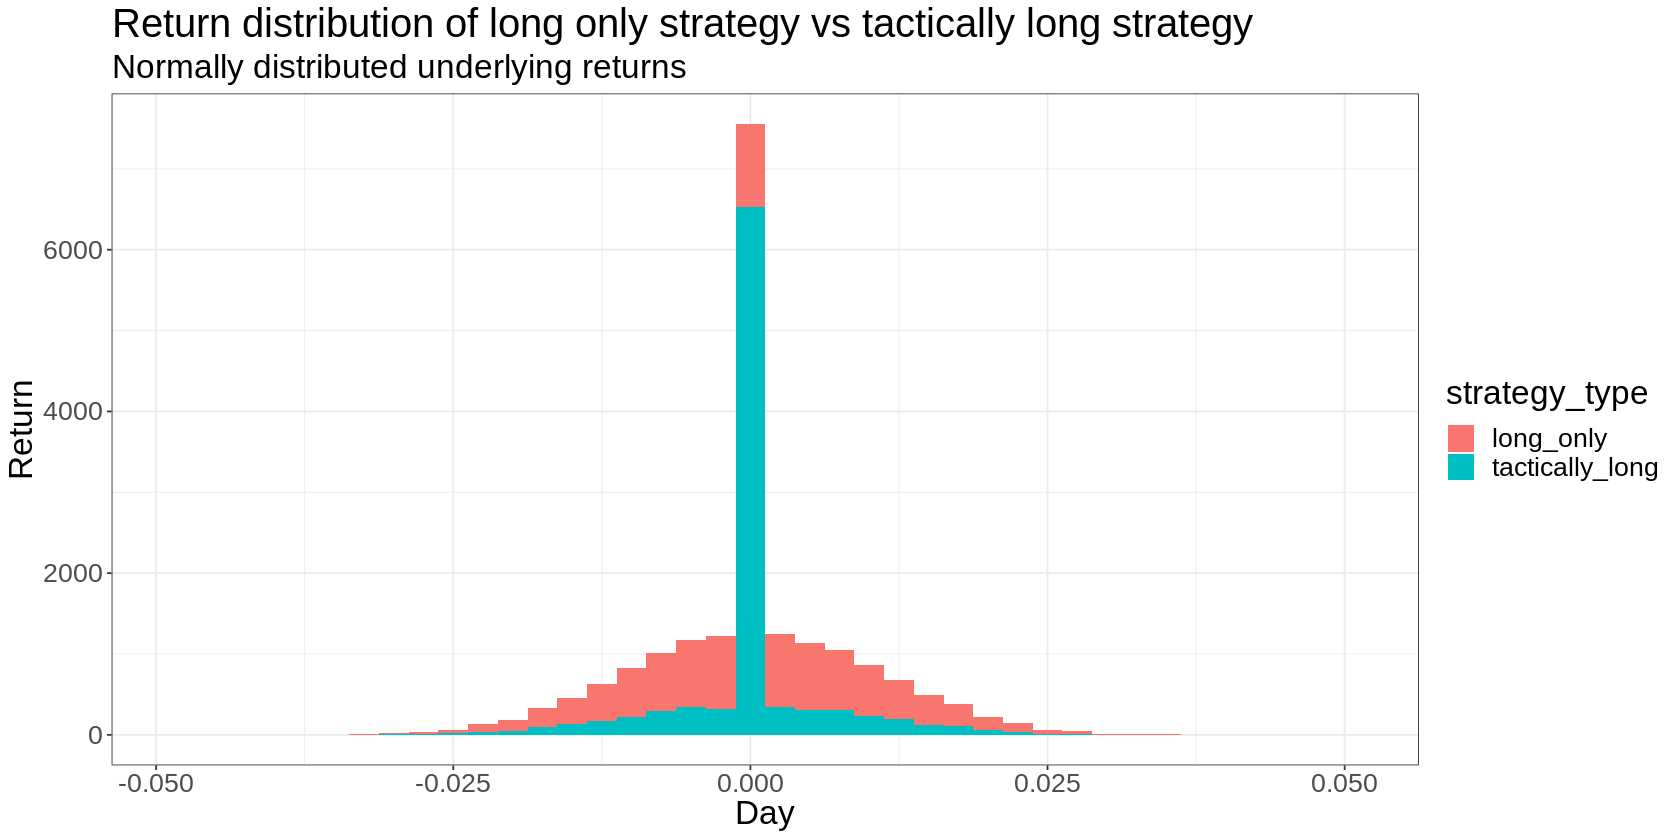

In [35]:
# plot cumulative returns
data.frame(
  day = 1:days,
  long_only = cumsum(returns),
  tactically_long = cumsum(strat_returns)
) %>%
  pivot_longer(-day, names_to = "strategy_type", values_to = "cumulative_return") %>%
  ggplot(aes(x = day, y = cumulative_return, colour = strategy_type)) +
  geom_line() +
  labs(
    x = "Day",
    y = "Cumulative Return",
    title = "Cumulative return of long only strategy vs tactically long strategy",
    subtitle = "Normally distributed underlying returns"
  )

# plot distribution of returns
data.frame(
  long_only = returns,
  tactically_long = strat_returns
) %>%
  pivot_longer(cols = everything(), names_to = "strategy_type", values_to = "return") %>%
  ggplot(aes(x = return, fill = strategy_type)) +
  geom_histogram(binwidth = 0.0025) +
  labs(
    x = "Day",
    y = "Return",
    title = "Return distribution of long only strategy vs tactically long strategy",
    subtitle = "Normally distributed underlying returns"
  )

What do you notice?

The stopping rule had an adverse impact on both total returns and risk-adjusted returns!

It didn't cut us off from further downside... but it *did* cut us off from the long-term expectancy of being long something that goes up.

Notice in the histogram that the stopping rule didn't alter the skew of the distribution... that is, it wasn't more effective at cutting us off from negative returns - it just reduced our exposure to something that goes up, on average.

Next, let's run the above simulation for many different realisations of history and compare Sharpes of our base case strategy and our tactical strategy, just to make sure this result isn't a fluke:

In [36]:
# do the above but in a matrix for many simulations, one column per simulation
set.seed(NULL)
nsims <- 1000
returns <- matrix(rnorm(days*nsims, mean_daily_return, vol), ncol = nsims, nrow = days)  # returns matrix

# calculate drawdown to use as stopping criterion
calc_dd <- function(x) {
  "x: returns vector"
  cumsum(x) - cummax(cumsum(x))
}

dd <- apply(returns, 2, calc_dd)  # dd matrix
dd <- rbind(rep(0, nsims), dd[-nrow(dd),])  # lag the dd matrix by 1

# create strategy returns
strat_returns <- returns
# add stopping rule - calculate drawdown
strat_returns[dd < dd_limit] <- 0

# compare sharpes
sharpe <- function(x) {
  "x: returns vector"
  sqrt(365)*mean(x)/sd(x)
}

base_case_sharpes <- apply(returns, 2, sharpe)
strategy_sharpes <- apply(strat_returns, 2, sharpe)

Here's a scatter plot of the base case sharpe vs the strategy sharpe for each realisation of history.

Points that fall above the blue line indicate realisations of history where the base case sharpe was higher than the strategy sharpe.

Points that fall below the blue line indicate realisations of history where the strategy sharpe was higher than the base case sharpe.

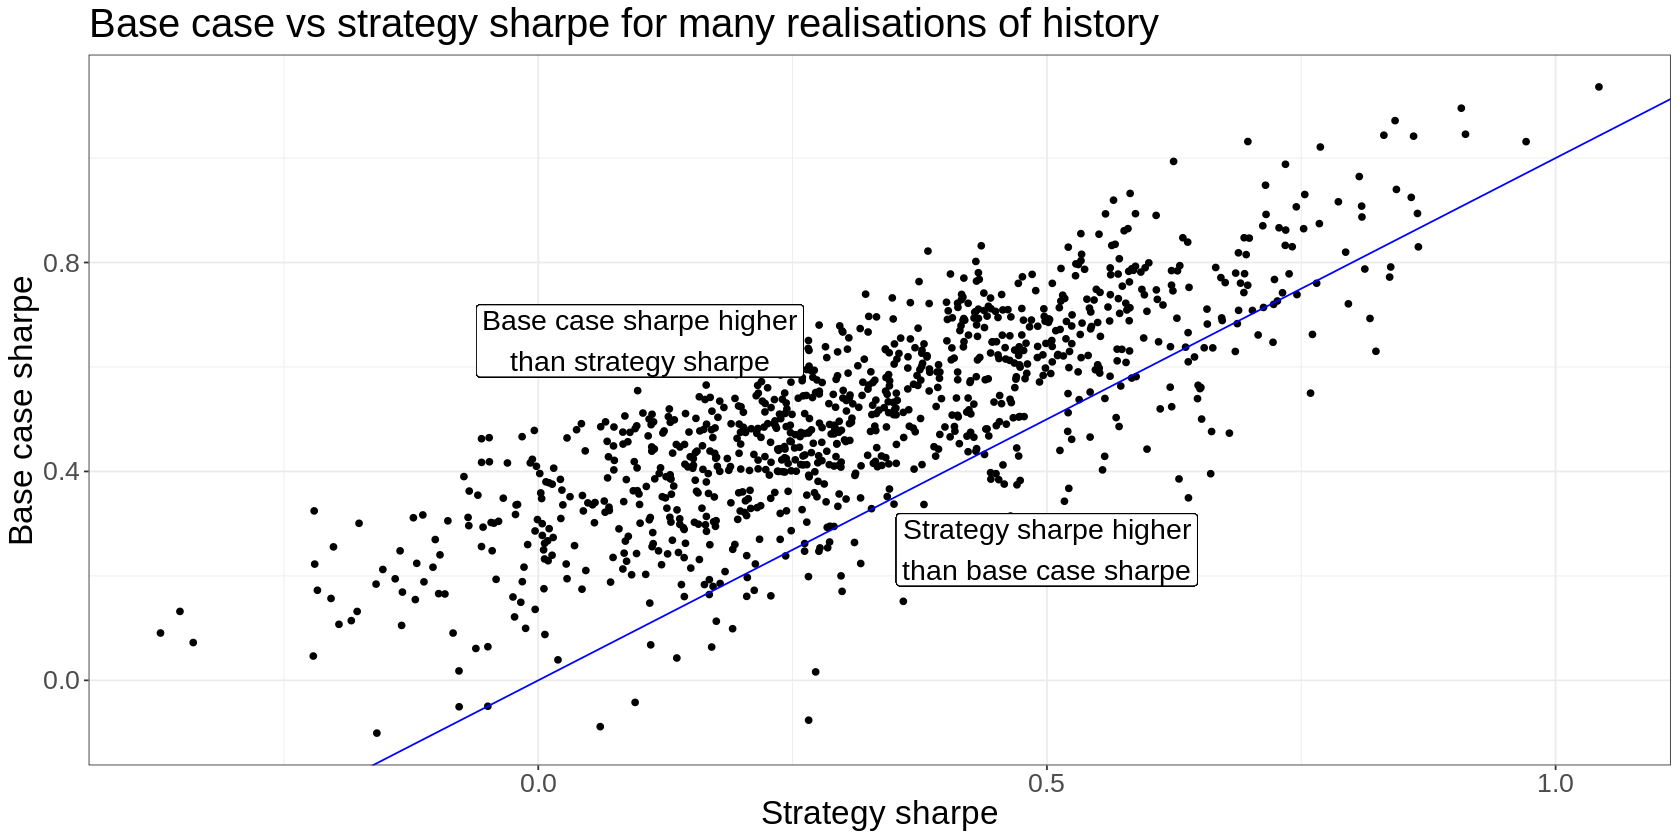

In [37]:
data.frame(
  base_case_sharpes = base_case_sharpes,
  strategy_sharpes = strategy_sharpes
) %>%
  ggplot(aes(x = strategy_sharpes, y = base_case_sharpes)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, colour = "blue") +
  geom_label(x = 0.1, y = 0.65, label = "Base case sharpe higher\nthan strategy sharpe", size = 6) +
  geom_label(x = 0.5, y = 0.25, label = "Strategy sharpe higher\nthan base case sharpe", size = 6) +
  labs(
    x = "Strategy sharpe",
    y = "Base case sharpe",
    title = "Base case vs strategy sharpe for many realisations of history"
  )

OK, I guess it wasn't a fluke then!

Here's another view of the above that compares the distribution of strategy sharpes and base case sharpes:

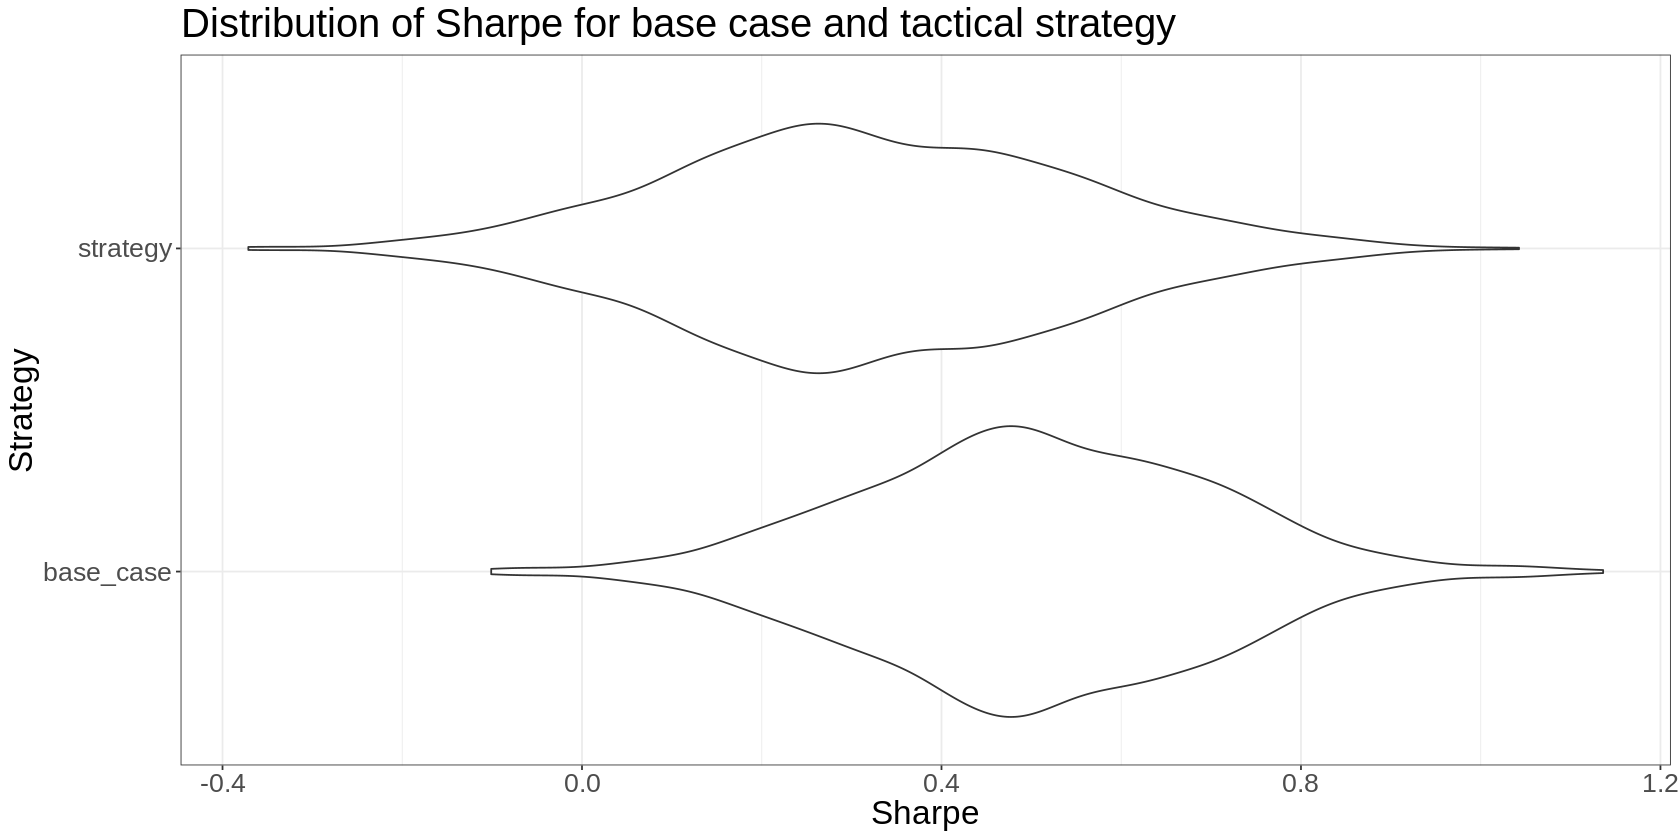

In [38]:
data.frame(
  base_case = base_case_sharpes,
  strategy = strategy_sharpes
) %>%
  pivot_longer(cols = everything(), names_to = "strategy", values_to = "sharpe") %>%
  ggplot(aes(x = sharpe, y = strategy)) +
    geom_violin() +
    labs(
      x = "Sharpe",
      y = "Strategy",
      title = "Distribution of Sharpe for base case and tactical strategy"
    )

Let's summarise what we can say so far...

When returns are sampled from the normal distribution with positive mean, adding a drawdown-based stopping rule has a negative impact on expected returns.

That leads us to the question "Under what conditions would a stopping rule increase expected returns?"

One condition that we *might* think fits the bill would be if our returns distribution is negatively skewed with some fat tails, like it often is in reality.

So let's generate a bunch of returns series with those characteristics and see what we find.

First, here's some code for generating negatively skewed, fat-tailed returns (thanks GPT for generating this code for me... saved me hours!!).

Let's see how the realised Sharpe compares to our constructed Sharpe of 0.5 in the limit, by taking a large sample:


In [39]:
skewed_fat_tailed_sample <- function(mu, sigma, nsims = 1) {

  # make a skewed, fat tailed distribution by combining distributions
  sample <- c(
  rnorm(n = nsims*1000, mean = mu, sd = sigma),
  rnorm(n = nsims*400, mean = -0.5*mu, sd = 1.5*sigma),
  rnorm(n = nsims*100, mean = 0.5*mu, sd = 1.5*sigma)
)

  sample
}

# Make returns of Sharpe 5 from skewed, fat tailed distribution
sharpe <- 0.5
ann_return <- 0.1
mean_daily_return <- ann_return/365
vol <- sqrt(365) * mean_daily_return/sharpe
# days <- 100000

returns <- skewed_fat_tailed_sample(mu = mean_daily_return, sigma = vol)
# check sharpe
sqrt(365) * mean(returns)/sd(returns)


[1] -0.307392

Our realised Sharpe is slightly lower than the Sharpe we tried to construct. That's because of the negative skew and fat tails in our returns. That's OK for our purposes though, since we only want to compare with the results from our tactical strategy.

Let's now make many simulations like we did previously and compare Sharpes:

In [40]:
# do the above but in a matrix for many simulations, one column per simulation
set.seed(NULL)
nsims <- 1000
returns <- matrix(skewed_fat_tailed_sample(mu = mean_daily_return, sigma = vol, nsims = nsims), ncol = nsims, nrow = 1500)

dd <- apply(returns, 2, calc_dd)  # dd matrix
dd <- rbind(rep(0, nsims), dd[-nrow(dd),])  # lag the dd matrix by 1

# create strategy returns
strat_returns <- returns
# add stopping rule - calculate drawdown
strat_returns[dd < dd_limit] <- 0

# compare sharpes
sharpe <- function(x) {
  "x: returns vector"
  sqrt(365)*mean(x)/sd(x)
}

base_case_sharpes <- apply(returns, 2, sharpe)
strategy_sharpes <- apply(strat_returns, 2, sharpe)

Plotting as before:

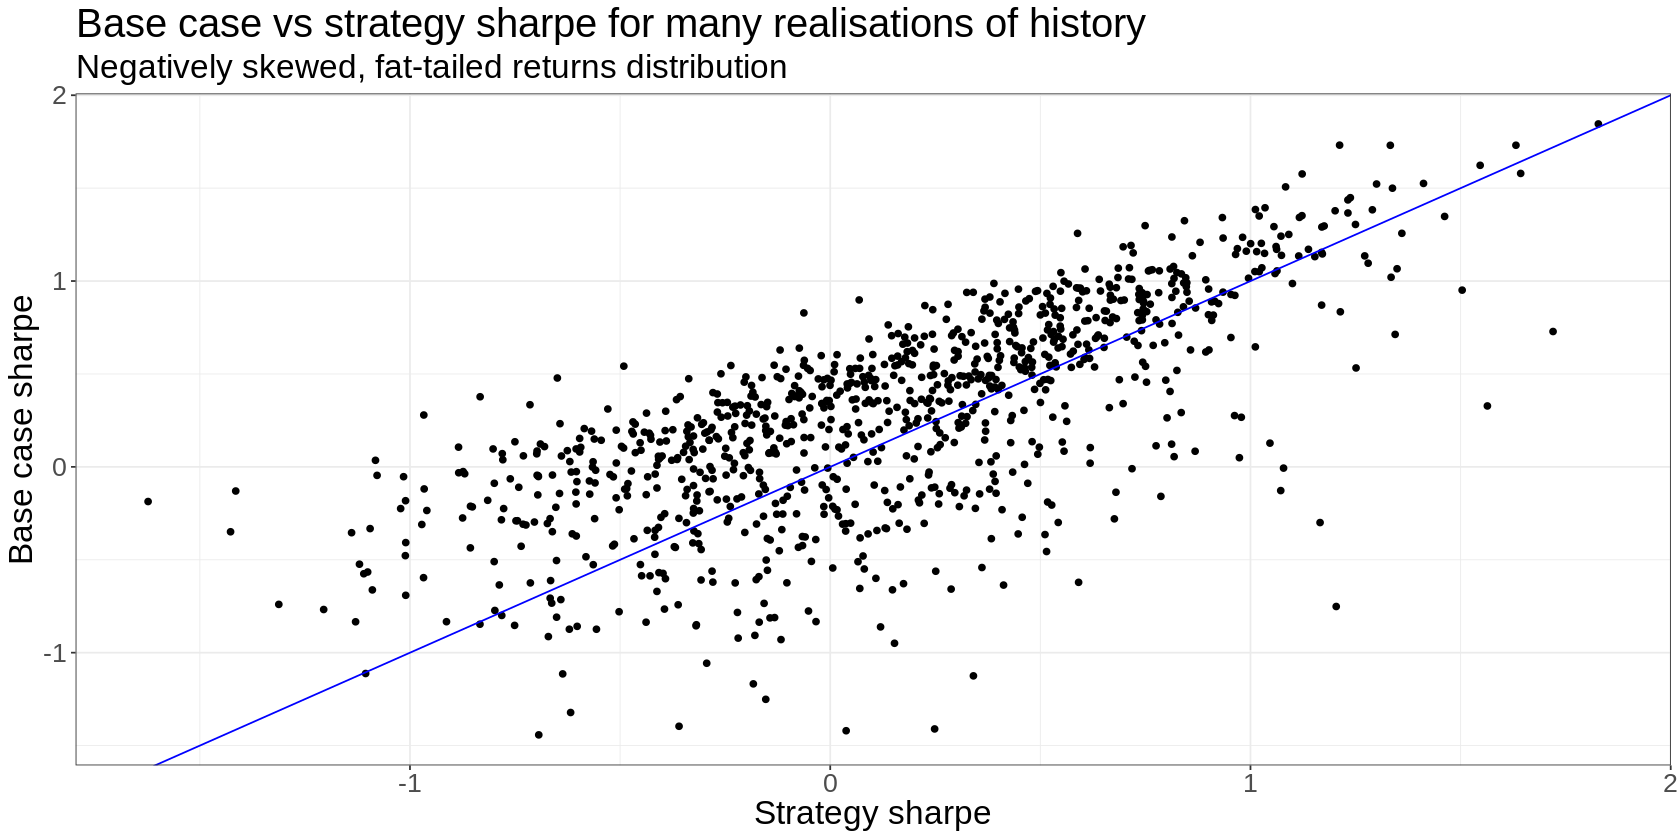

In [41]:
data.frame(
  base_case_sharpes = base_case_sharpes,
  strategy_sharpes = strategy_sharpes
) %>%
  ggplot(aes(x = strategy_sharpes, y = base_case_sharpes)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, colour = "blue") +
  # geom_label(x = 0.1, y = 0.65, label = "Base case sharpe higher\nthan strategy sharpe", size = 6) +
  # geom_label(x = 0.5, y = 0.25, label = "Strategy sharpe higher\nthan base case sharpe", size = 6) +
  labs(
    x = "Strategy sharpe",
    y = "Base case sharpe",
    title = "Base case vs strategy sharpe for many realisations of history",
    subtitle = "Negatively skewed, fat-tailed returns distribution"
  )

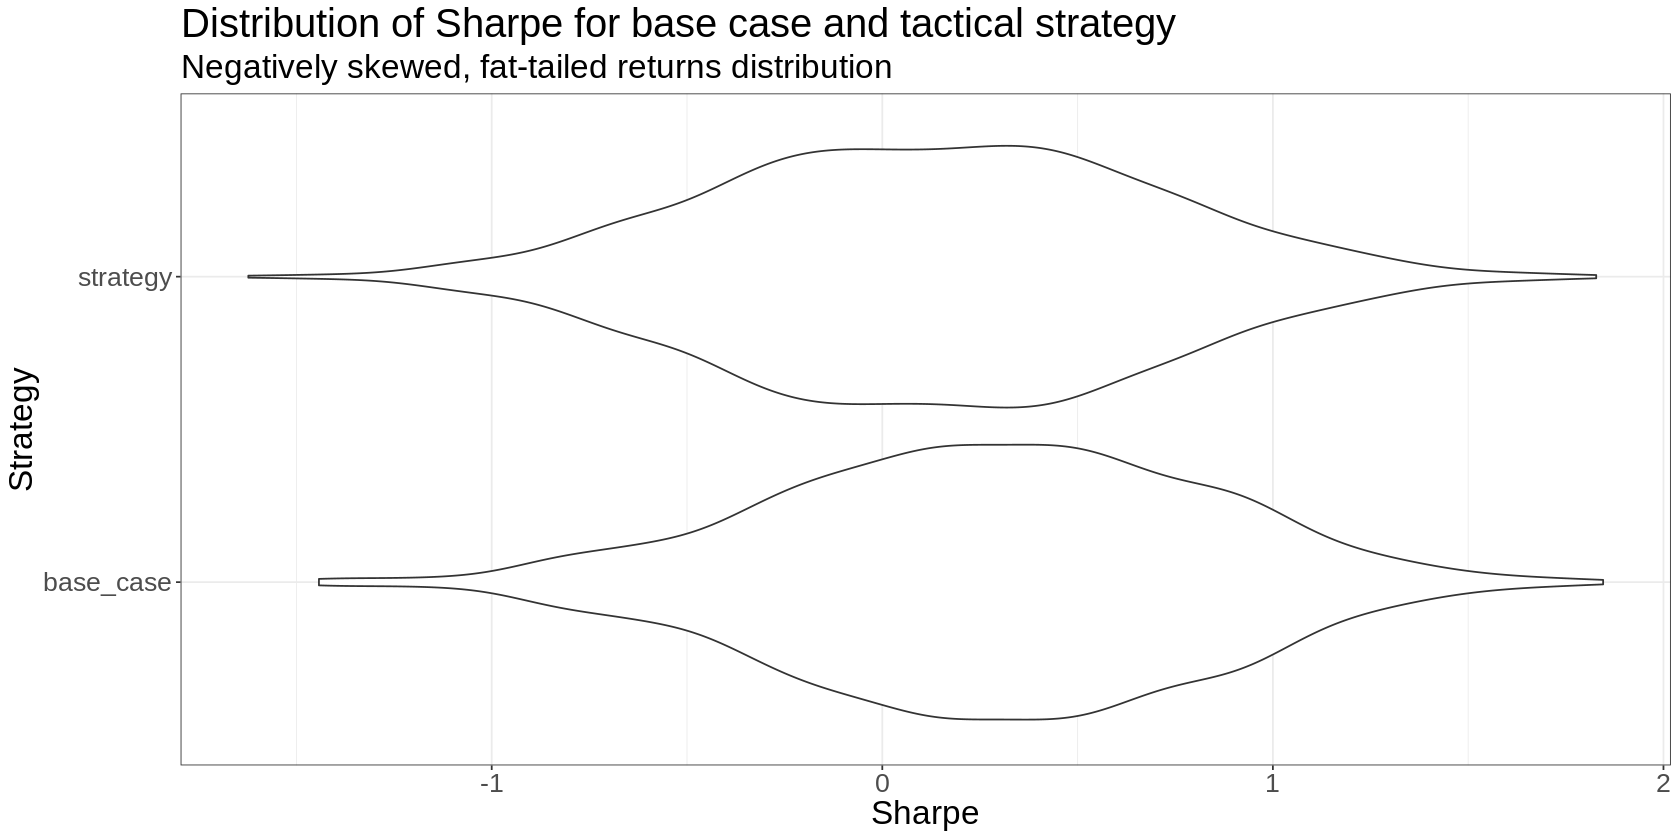

In [42]:
data.frame(
  base_case = base_case_sharpes,
  strategy = strategy_sharpes
) %>%
  pivot_longer(cols = everything(), names_to = "strategy", values_to = "sharpe") %>%
  ggplot(aes(x = sharpe, y = strategy)) +
    geom_violin() +
    labs(
      x = "Sharpe",
      y = "Strategy",
      title = "Distribution of Sharpe for base case and tactical strategy",
      subtitle = "Negatively skewed, fat-tailed returns distribution"
    )

We find that again stopping rules don't actually improve expected returns.

Realised volatility will be higher. This implies that we'll be in drawdown more often, and therefore would be cut off more often from the positive long-run expectancy.

The important assumption built into our data here is that negative returns don't predict negative returns. Despite our returns having negative skewness and fatter tails, there's no inherent dependency on the sign of the previous return.

What if we changed that assumption? What if our returns were correlated with previous returns? That is, what if our returns series was autocorrelated?

To construct an autocorrelated series, we need to make the next value in the series dependent on the previous. That implies that we have to do this in a loop, which is going to be tedious. Let's get stuck in:

In [43]:
days <- 1000

x <- c(0)

for(i in 2:days) {
  x[i] <- rnorm(1, ann_return/365, vol) + x[i-1]*0.5  # make the next value dependent on the previous one
}

You can visually detect some obvious "trendiness" in this series:




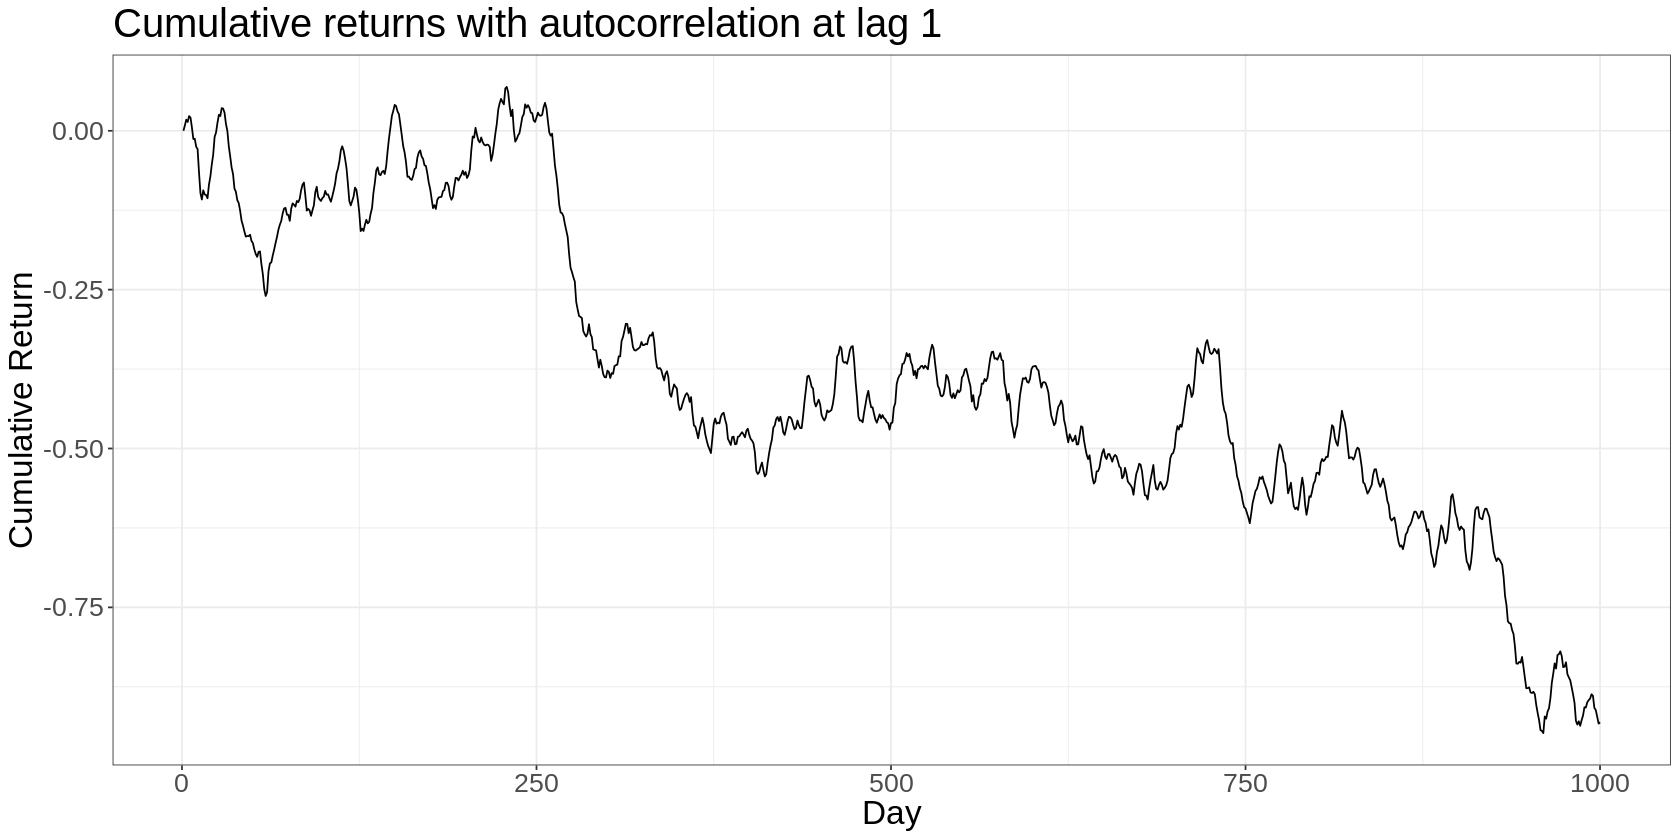

In [44]:
data.frame(
  Day = 1:days,
  returns = x,
  cum_return = cumsum(x)
) %>%
ggplot(aes(x = Day, y = cum_return)) +
geom_line() +
labs(
  y = "Cumulative Return",
  title = "Cumulative returns with autocorrelation at lag 1"
)

Here's a scatter plot of today's return vs yesterday's return:

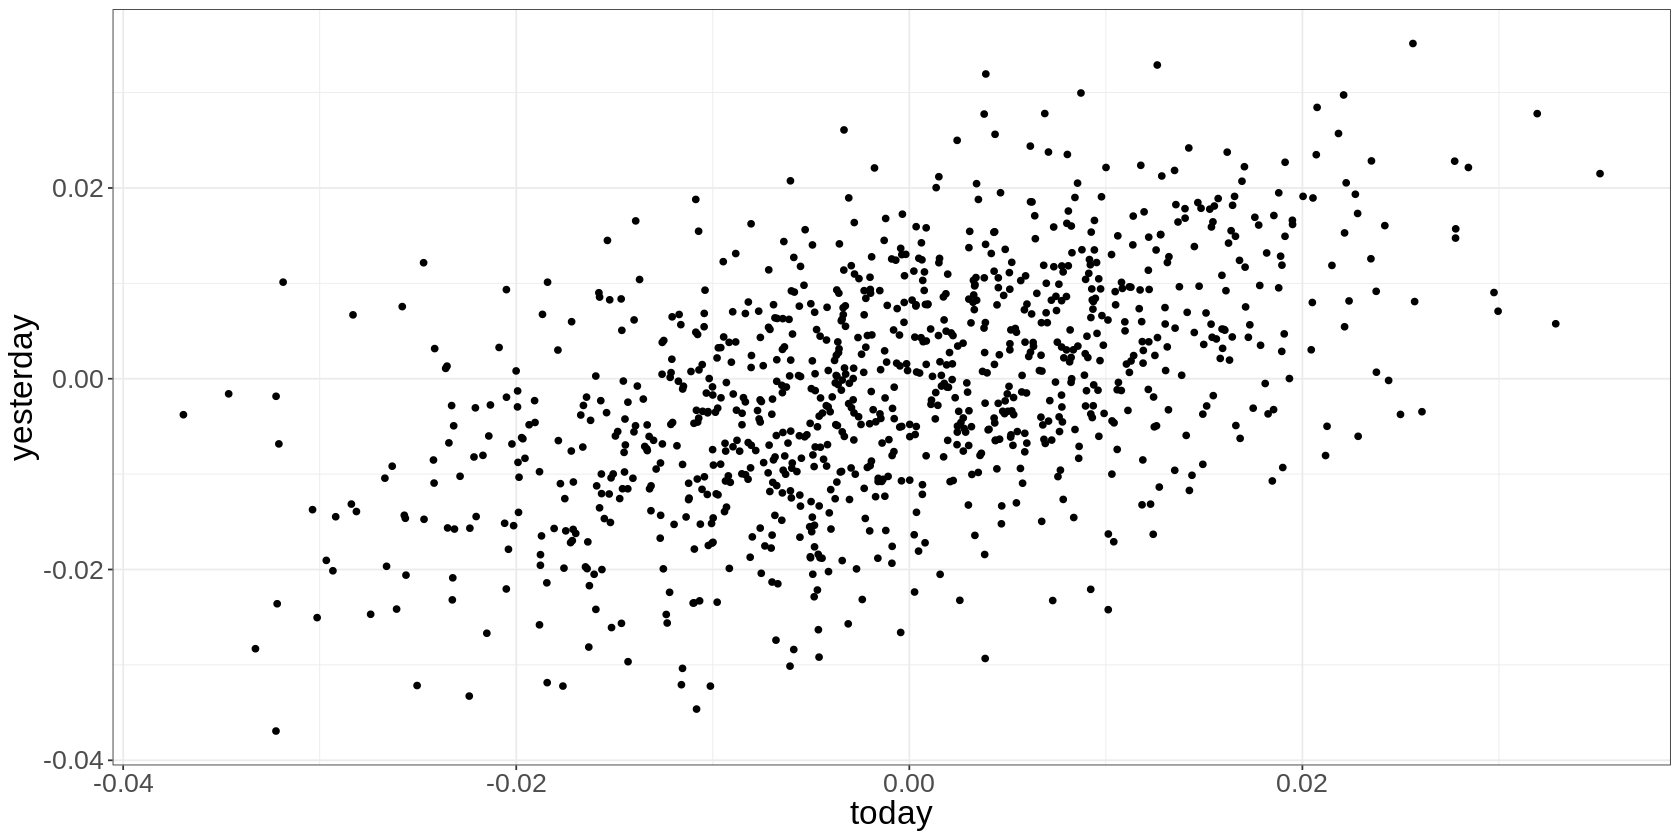

In [45]:
# plot values at t vs t-1
data.frame(
  today = x[2:days],
  yesterday = x[1:days-1]
) %>%
  ggplot(aes(x = today, y = yesterday)) +
  geom_point()

The correlation is quite obvious.


You could do the same thing but construct autocorrelations at any lags. Here's how you might construct a returns series that was acutocorrelated at lags 1 and 2 for instance:

In [46]:
y <- c(0, 0)
for(i in 3:days) {
  y[i] <- rnorm(1, ann_return/365, vol) + y[i-1]*0.4 + y[i-2]*0.4
}

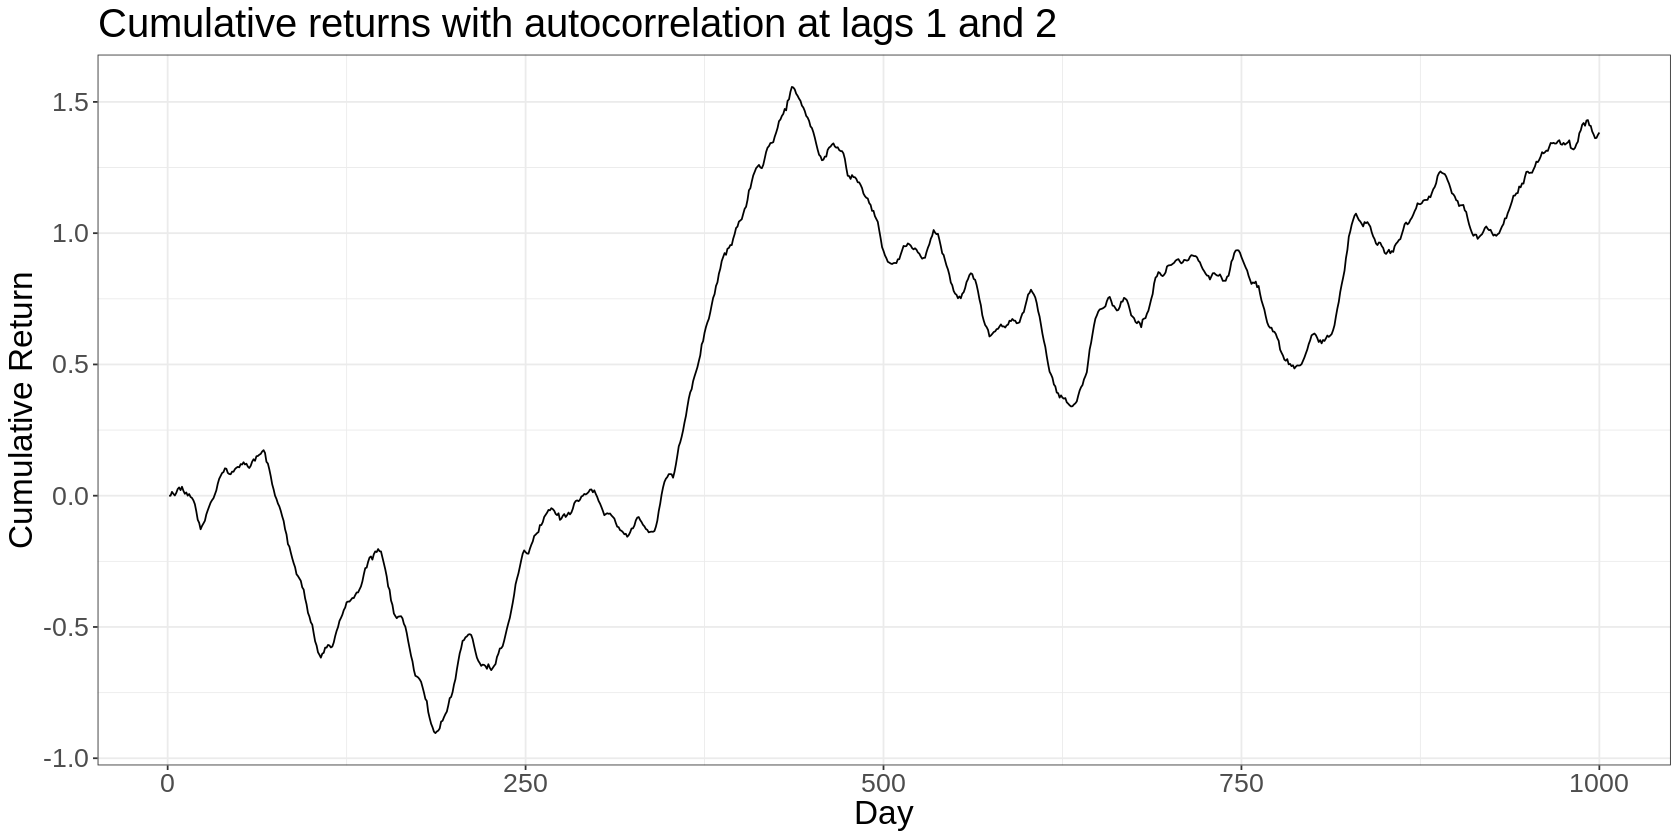

In [47]:
data.frame(
  Day = 1:days,
  returns = y,
  cum_return = cumsum(y)
) %>%
ggplot(aes(x = Day, y = cum_return)) +
geom_line() +
labs(
  y = "Cumulative Return",
  title = "Cumulative returns with autocorrelation at lags 1 and 2"
)

Let's keep it simple though and just create a lag-1 autocorrelated returns series and see what happens if we trade it long with a stopping rule:

In [48]:
set.seed(234)

days <- 1000
returns <- c(0)
for(i in 2:days) {
  returns[i] <- rnorm(1, ann_return/365, vol) + returns[i-1]*0.4  # make the next value dependent on the previous one
}

# create strategy rules
strat_returns <- returns
# add stopping rule - calculate drawdown... do vectorised for performance later
dd <- cumsum(returns) - cummax(cumsum(returns))
strat_returns[pmin(which(dd < dd_limit)+1, days)] = 0  # simple vectorised version that lags the drawdown signal

# compare sharpes
base_case_sharpe <- sqrt(365) * mean(returns)/sd(returns)
strategy_sharpe <- sqrt(365) * mean(strat_returns)/sd(strat_returns)
print(glue(
  "Sharpe of long-only-all-the-time strategy: {round(base_case_sharpe, 2)}
  Sharpe of tactically long strategy: {round(strategy_sharpe, 2)}"
))

Sharpe of long-only-all-the-time strategy: 0.15
Sharpe of tactically long strategy: 0.47


Now things are getting interesting! In this single realisation of history, our stopping rules increased our returns.

Let's plot the cumulative returns to the base case and the strategy, and their return histograms:

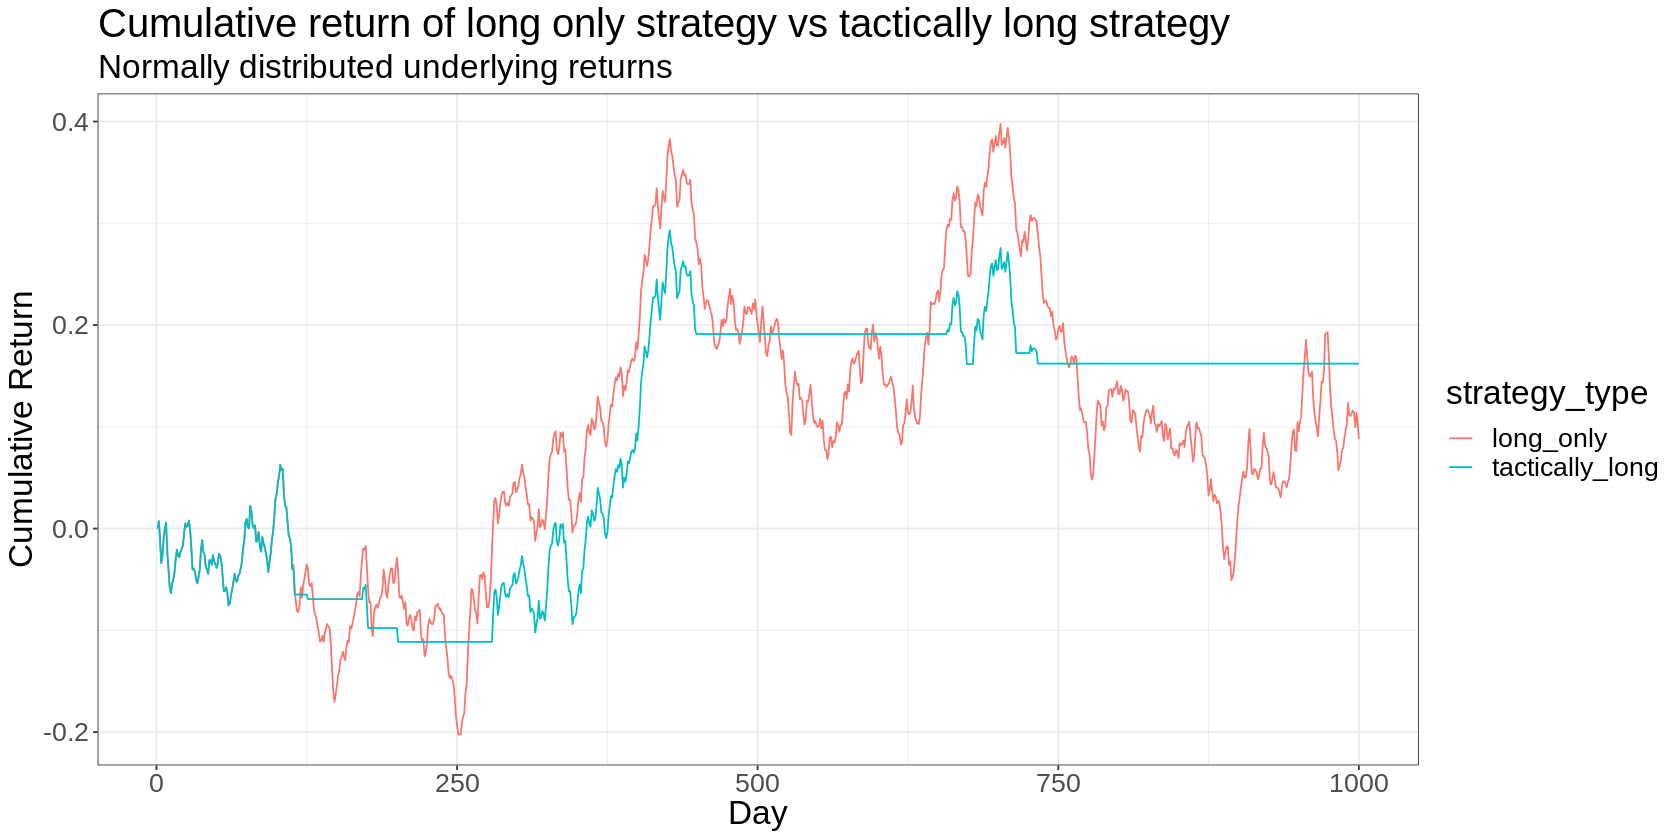

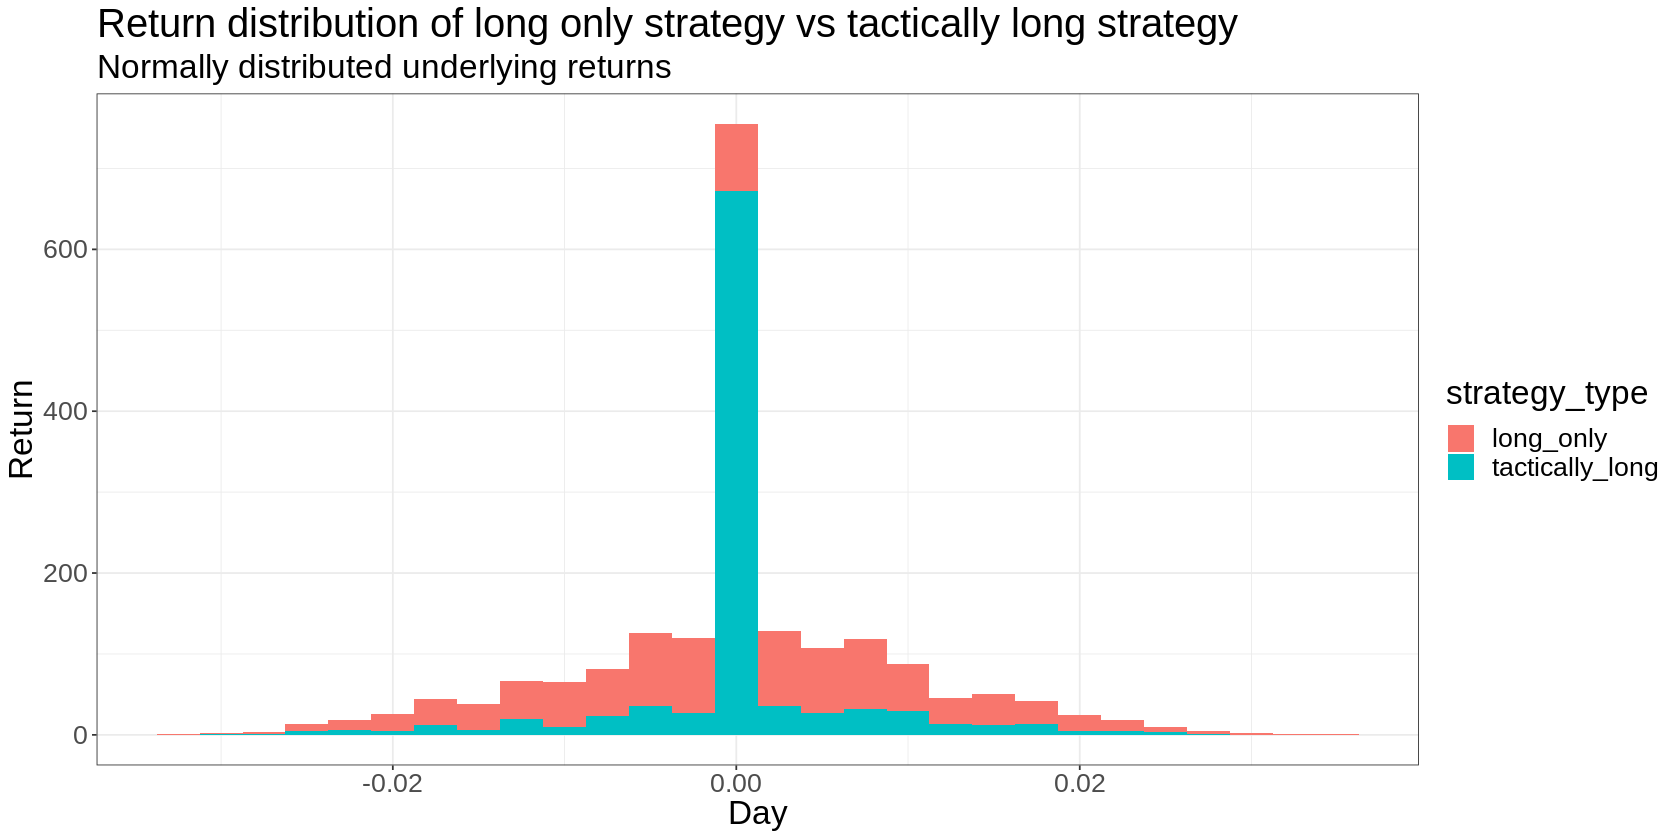

In [49]:
# plot cumulative returns
data.frame(
  day = 1:days,
  long_only = cumsum(returns),
  tactically_long = cumsum(strat_returns)
) %>%
  pivot_longer(-day, names_to = "strategy_type", values_to = "cumulative_return") %>%
  ggplot(aes(x = day, y = cumulative_return, colour = strategy_type)) +
  geom_line() +
  labs(
    x = "Day",
    y = "Cumulative Return",
    title = "Cumulative return of long only strategy vs tactically long strategy",
    subtitle = "Normally distributed underlying returns"
  )

# plot distribution of returns
data.frame(
  long_only = returns,
  tactically_long = strat_returns
) %>%
  pivot_longer(cols = everything(), names_to = "strategy_type", values_to = "return") %>%
  ggplot(aes(x = return, fill = strategy_type)) +
  geom_histogram(binwidth = 0.0025) +
  labs(
    x = "Day",
    y = "Return",
    title = "Return distribution of long only strategy vs tactically long strategy",
    subtitle = "Normally distributed underlying returns"
  )

In this case, since our returns series is autocorrelated, our stopping rule cut us off from some negative returns. While the total returns to our tactical strategy were similar (we're still cutting ourselves off from the returns of a thing that goes up on average), our risk-adjusted returns were higher.

Let's see if this is true generally, or if this was just a fluke.

In [50]:
# do the above but in a matrix for many simulations, one column per simulation
set.seed(NULL)
nsims <- 1000
days <- 1000
returns <- c(0)
for(i in 2:(days*nsims)) {
  returns[i] <- rnorm(1, ann_return/365, vol) + returns[i-1]*0.4  # make the next value dependent on the previous one
}
returns <- matrix(returns, ncol = nsims, nrow = days)

dd <- apply(returns, 2, calc_dd)  # dd matrix
dd <- rbind(rep(0, nsims), dd[-nrow(dd),])  # lag the dd matrix by 1

# create strategy returns
strat_returns <- returns
# add stopping rule - calculate drawdown
strat_returns[dd < dd_limit] <- 0

# compare sharpes
sharpe <- function(x) {
  "x: returns vector"
  sqrt(365)*mean(x)/sd(x)
}

base_case_sharpes <- apply(returns, 2, sharpe)
strategy_sharpes <- apply(strat_returns, 2, sharpe)

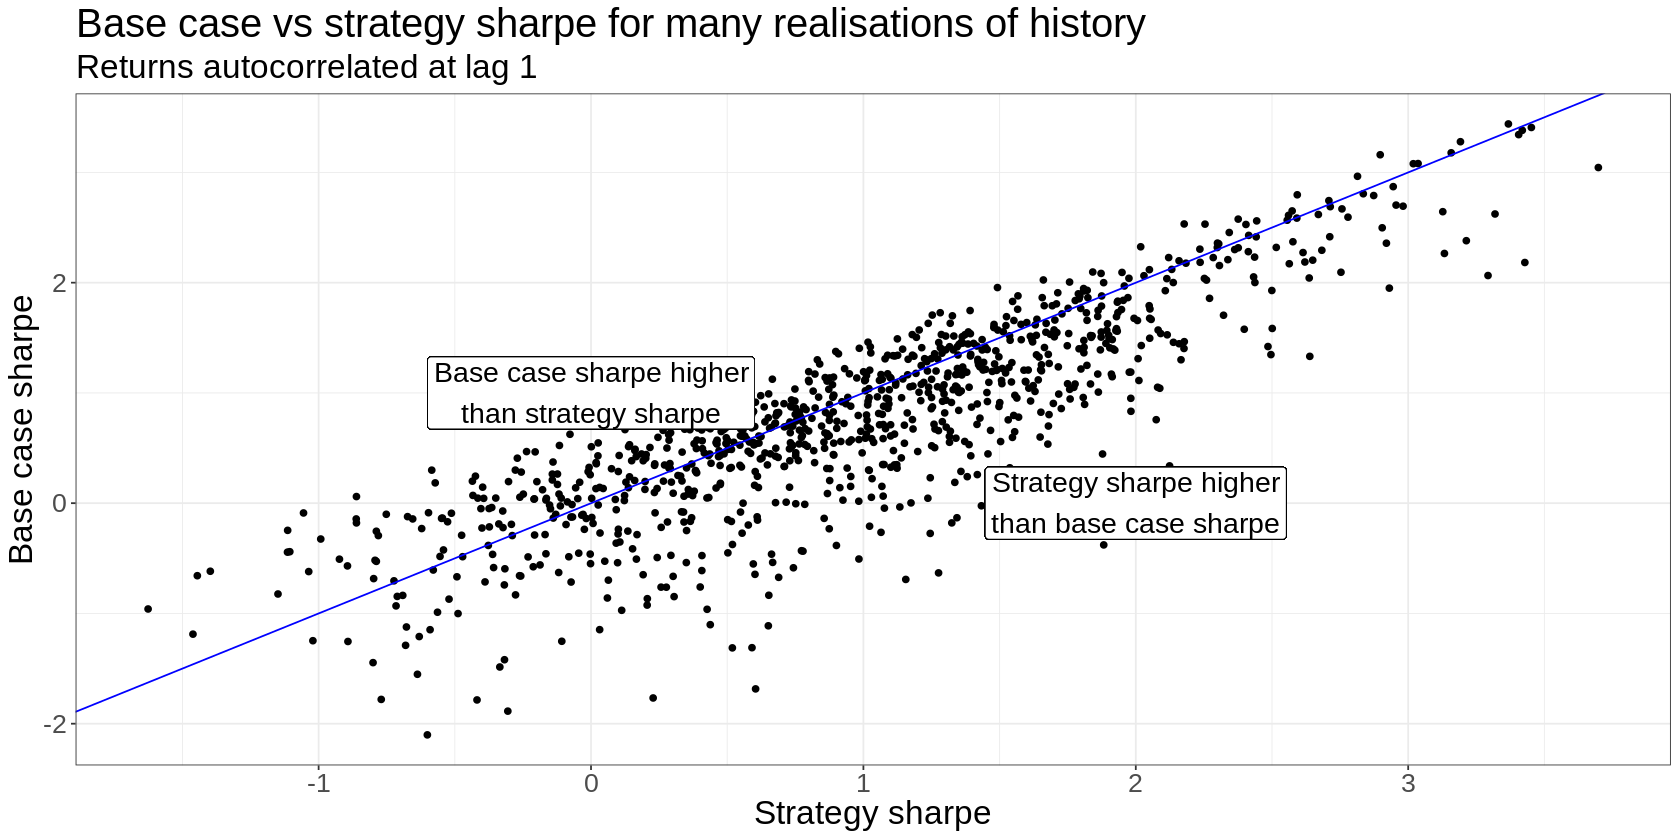

In [51]:
data.frame(
  base_case_sharpes = base_case_sharpes,
  strategy_sharpes = strategy_sharpes
) %>%
  ggplot(aes(x = strategy_sharpes, y = base_case_sharpes)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, colour = "blue") +
  geom_label(x = 0, y = 1, label = "Base case sharpe higher\nthan strategy sharpe", size = 6) +
  geom_label(x = 2, y = 0, label = "Strategy sharpe higher\nthan base case sharpe", size = 6) +
  labs(
    x = "Strategy sharpe",
    y = "Base case sharpe",
    title = "Base case vs strategy sharpe for many realisations of history",
    subtitle = "Returns autocorrelated at lag 1"
  )

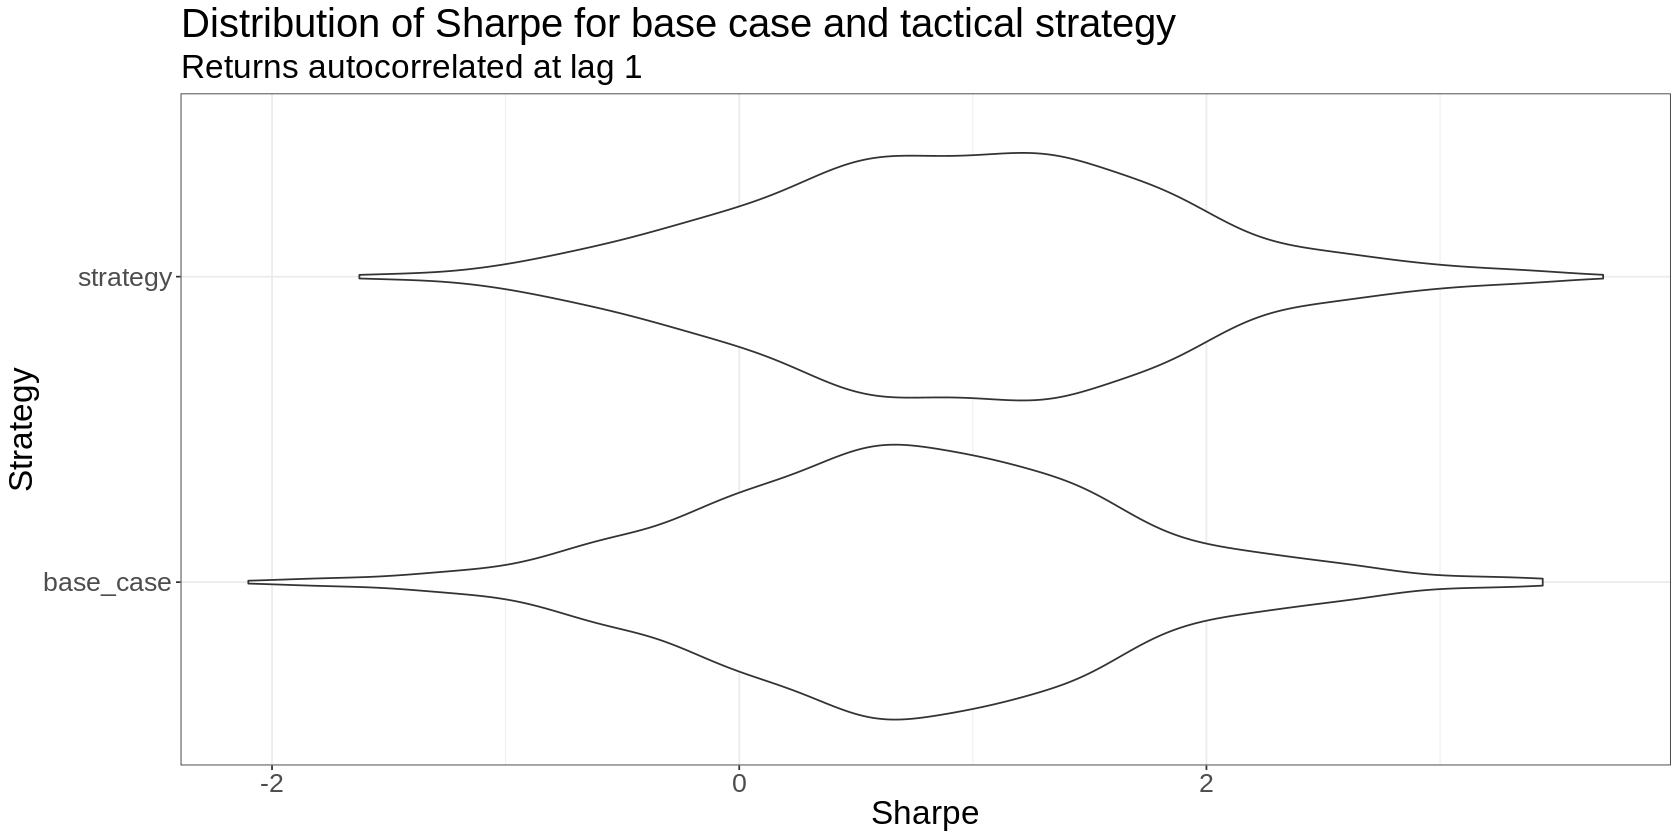

In [52]:
data.frame(
  base_case = base_case_sharpes,
  strategy = strategy_sharpes
) %>%
  pivot_longer(cols = everything(), names_to = "strategy", values_to = "sharpe") %>%
  ggplot(aes(x = sharpe, y = strategy)) +
    geom_violin() +
    labs(
      x = "Sharpe",
      y = "Strategy",
      title = "Distribution of Sharpe for base case and tactical strategy",
      subtitle = "Returns autocorrelated at lag 1"
    )

In this case, our stopping rule does increase risk adjusted returns, on average - though it isn't a sliver bullet by any stretch.

But are our returns actually autocorrelated? Usually not. Check out the ACF of SPY:

In [53]:
spy <- single_ticker_prices_yahoo("BTC-USD", from_date = "2014-10-01") %>%
  mutate(log_return = log(Adj.Close/dplyr::lag(Adj.Close))) %>%
  na.omit()

head(spy)

Date       Open    High    Low     Close   Adj.Close Volume   log_return 
2 2014-10-02 383.988 385.497 372.946 375.072 375.072   21777700 -0.02252144
3 2014-10-03 375.181 377.695 357.859 359.512 359.512   30901200 -0.04237045
4 2014-10-04 359.892 364.487 325.886 328.866 328.866   47236500 -0.08909717
5 2014-10-05 328.916 341.801 289.296 320.510 320.510   83308096 -0.02573686
6 2014-10-06 320.389 345.134 302.560 330.079 330.079   79011800  0.02941854
7 2014-10-07 330.584 339.247 320.482 336.187 336.187   49199900  0.01833554

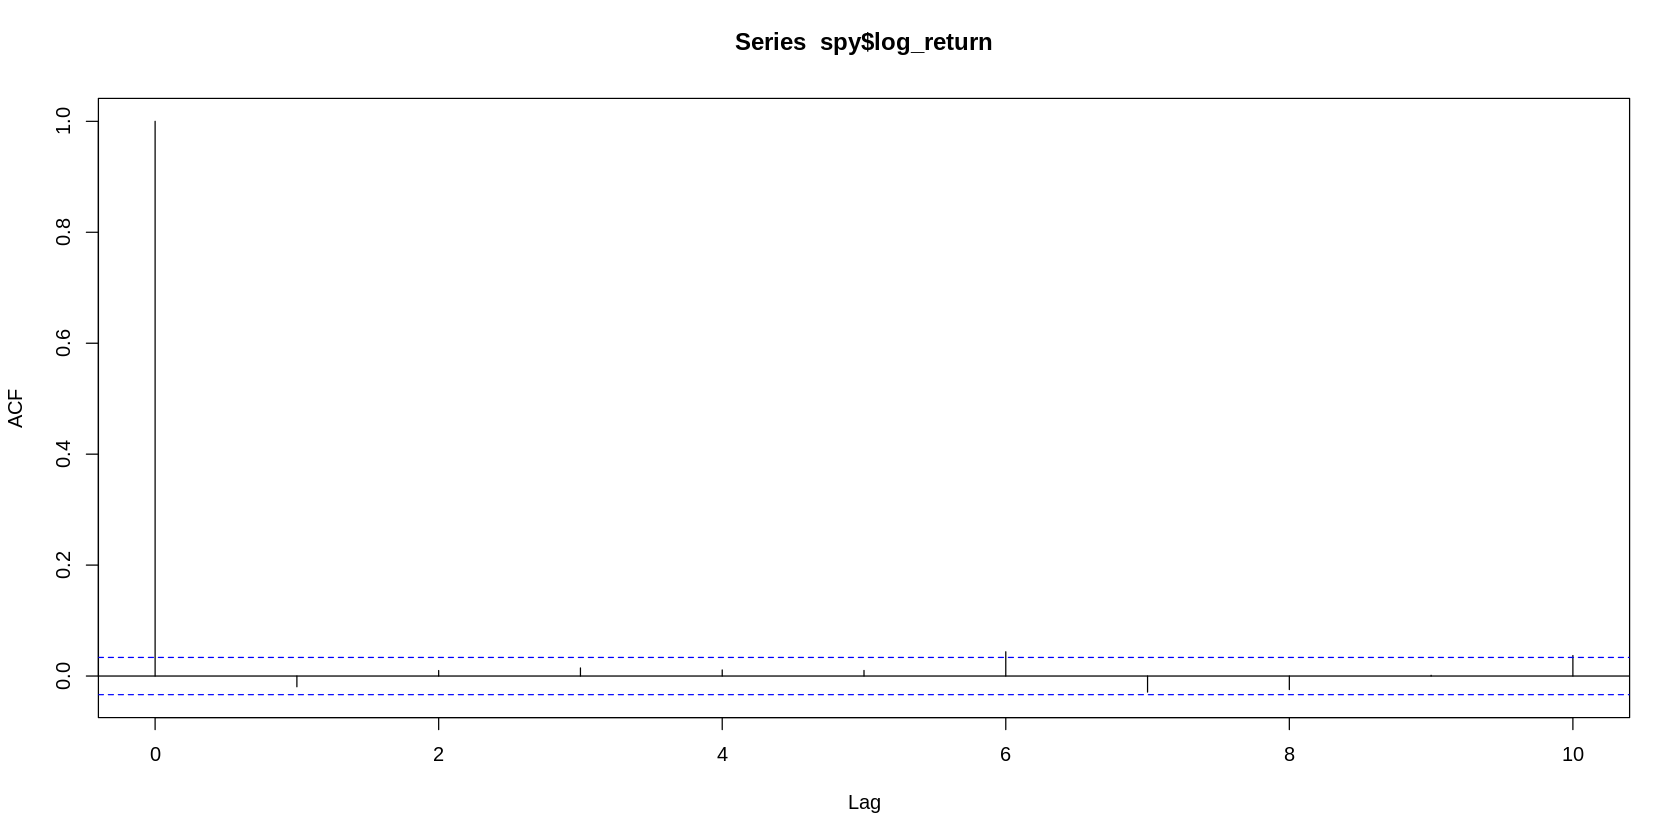

In [54]:
acf(spy$log_return, lag.max = 10)

We actually see the opposite... we see negative autocorrelation at the first lag - albeit of much smaller magnitude than we used in our example above.

So when would returns be autocorrelated? When we have evidence of trend - for instance, historically in crypto and commodities.

What happens when returns are anti-autocorrelated? For instance like in the SPY returns above, or in the case of a mean-reverting strategy such as pairs trading?

To investigate, simply reverse the sign of the autocorrelation in our constructed returns series:

In [55]:
# do the above but in a matrix for many simulations, one column per simulation
set.seed(NULL)
nsims <- 1000
days <- 1000
returns <- c(0)
for(i in 2:(days*nsims)) {
  returns[i] <- rnorm(1, ann_return/365, vol) + returns[i-1]*-0.4  # make the next value dependent on the previous one
}
returns <- matrix(returns, ncol = nsims, nrow = days)

dd <- apply(returns, 2, calc_dd)  # dd matrix
dd <- rbind(rep(0, nsims), dd[-nrow(dd),])  # lag the dd matrix by 1

# create strategy returns
strat_returns <- returns
# add stopping rule - calculate drawdown
strat_returns[dd < dd_limit] <- 0

# compare sharpes
sharpe <- function(x) {
  "x: returns vector"
  sqrt(365)*mean(x)/sd(x)
}

base_case_sharpes <- apply(returns, 2, sharpe)
strategy_sharpes <- apply(strat_returns, 2, sharpe)

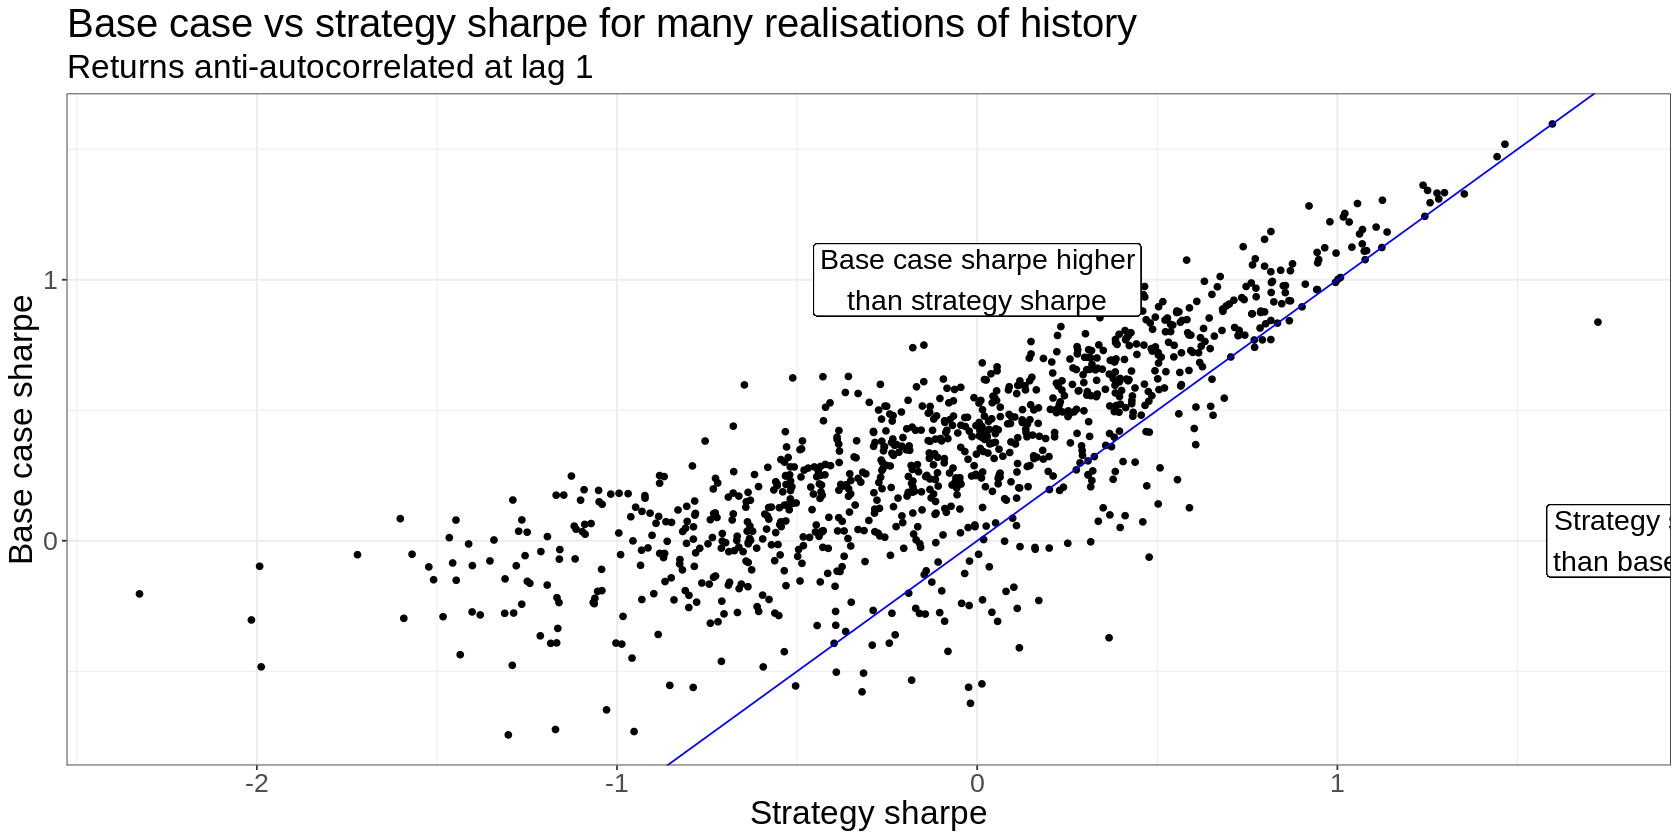

In [56]:
data.frame(
  base_case_sharpes = base_case_sharpes,
  strategy_sharpes = strategy_sharpes
) %>%
  ggplot(aes(x = strategy_sharpes, y = base_case_sharpes)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, colour = "blue") +
  geom_label(x = 0, y = 1, label = "Base case sharpe higher\nthan strategy sharpe", size = 6) +
  geom_label(x = 2, y = 0, label = "Strategy sharpe higher\nthan base case sharpe", size = 6) +
  labs(
    x = "Strategy sharpe",
    y = "Base case sharpe",
    title = "Base case vs strategy sharpe for many realisations of history",
    subtitle = "Returns anti-autocorrelated at lag 1"
  )

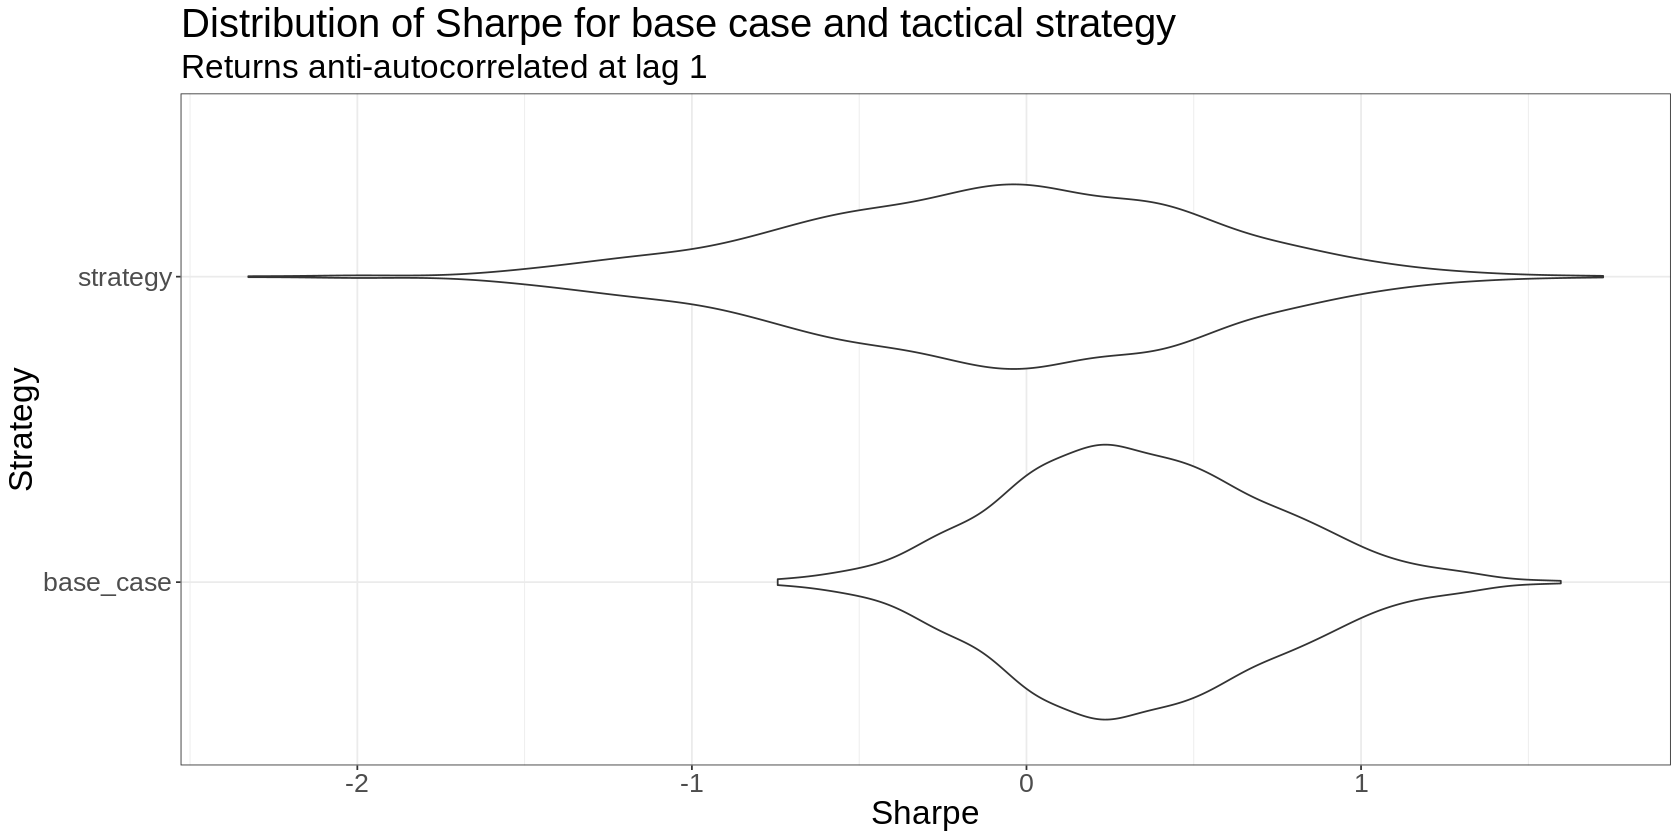

In [57]:
data.frame(
  base_case = base_case_sharpes,
  strategy = strategy_sharpes
) %>%
  pivot_longer(cols = everything(), names_to = "strategy", values_to = "sharpe") %>%
  ggplot(aes(x = sharpe, y = strategy)) +
    geom_violin() +
    labs(
      x = "Sharpe",
      y = "Strategy",
      title = "Distribution of Sharpe for base case and tactical strategy",
      subtitle = "Returns anti-autocorrelated at lag 1"
    )

As you'd expect, in the mean-reverting case we decrease our risk-adjusted returns with a profit-based stopping rule. Hence why we tend to use a time-based stop or some other criterion for unwinding a pairs trade.
